# A2C

### Advantage
- 예상했던 것 (V(s))보다 얼마나 더 좋은 값인가?
- A(s,a) = Q(s,a) - V(s)
- Q(s,a) = R + rV(s')
=> A(s,a) = R + rV(s') - V(s)

: Critic Network에서 계산한 V(s)가 Actor Network의 계산에도 영향을 끼침

In [1]:
import os
import random
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from libs.utils import *
from libs.generate_boxes import *

In [13]:
def cuboid_data2(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt2(positions,sizes=None,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data2(p, size=s) )
    return Poly3DCollection(np.concatenate(g),facecolors=np.repeat(colors,6), alpha=0.5, **kwargs)

def get_colors(n_box):
    color_names=["crimson","limegreen","grey","brown","orange","olive","blue","purple","yellow","pink","skyblue","red","aqua","gold"]
    colors = color_names*(n_box//len(color_names))+color_names[:n_box%len(color_names)]
    return colors

def vis_box(sizes,positions,fs=(10,5), title=''):
    colors = get_colors(len(positions))
    plt.figure('SPLTV', figsize=(15,5))
    #ax = fig.gca(projection='3d')
    ax = plt.subplot(141, projection='3d')
    #ax.set_aspect('auto')
    plt.title(title)
    #ax.subplot(sub[0],sub[1],sub[2],projection='3d')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([-5,25])
    ax.set_ylim([-5,25])
    ax.set_zlim([-5,25])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax = plt.subplot(142,projection='3d')
    plt.title(title + '(z)')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([0,20])
    ax.set_ylim([0,20])
    ax.set_zlim([0,20])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(90,-90)
    
    ax = plt.subplot(143,projection='3d')
    plt.title(title + '(x)')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([0,20])
    ax.set_ylim([0,20])
    ax.set_zlim([0,20])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(0,0)
    
    ax = plt.subplot(144,projection='3d')
    plt.title(title + '(y)')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([0,20])
    ax.set_ylim([0,20])
    ax.set_zlim([0,20])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(0,-90)
    
    plt.show()

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [4]:
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False

        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        self.actor = self.build_actor()
        self.critic = self.build_critic()

    def build_actor(self):
        actor = Sequential(name = 'actor')
        actor.add(Dense(24, input_dim=self.state_size, activation='relu'))
        if self.action_size == 1:
            actor.add(Dense(self.action_size, activation='linear'))
        else:
            actor.add(Dense(self.action_size, activation='softmax'))
        actor.summary()
        actor.compile(loss='mse', optimizer=Adam(lr=self.actor_lr))
        return actor

    def build_critic(self):
        critic = Sequential(name = 'critic')
        critic.add(Dense(24, input_dim=self.state_size, activation='relu'))
        critic.add(Dense(self.value_size, activation='linear'))
        critic.summary()
        critic.compile(loss='mse', optimizer=Adam(lr=self.critic_lr))
        return critic

    def get_action(self, state, action_size):
        policy = self.actor.predict(state, batch_size=1).flatten()
        org_policy = policy
        #print('org:',  policy)
        
        if action_size > self.action_size:
            policy = policy[:action_size]
        elif action_size < self.action_size:
            policy = policy[:action_size]
            if sum(policy) == 0:
                if action_size == 1: policy = np.array([1.])
                elif action_size == 2: policy = np.array([0.5, 0.5])
                elif action_size == 3: policy = np.array([0.33, 0.33, 0.34])
            else:
                p_list = []
                for p in policy:
                    p_list.append(p)
                p_list = np.array(p_list)
                m = 1/sum(p_list)
                m = m
                for i in range(len(p_list)):
                    p_list[i] = p_list[i] * m
                policy = p_list
        return np.random.choice(action_size, 1, p=policy)[0]

    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
            print('DONE', 'Adv:', advantages[0][action], 'target:', target[0][0],
             'reward:', reward, 'value:', value)
        else:
            next_value = self.critic.predict(next_state)[0]
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value
            print('Adv:', advantages[0][action], 'target:', target[0][0],
             'reward:', reward, 'value:', value, 'next_value:', next_value)
        
        self.actor_history = self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic_history = self.critic.fit(state, target, epochs=1, verbose=0)

In [5]:
class Bpp3DEnv():
    def __init__(self,length=20, breadth=20, height=20):
        super(Bpp3DEnv, self).__init__()
        self.length=length
        self.breadth=breadth
        self.height=height
        self.container=np.zeros((self.length,self.breadth))
    
    def step(self, upleft,bxl,bxb,bxh):
        self.container[upleft[0]:upleft[0]+bxl,upleft[1]:upleft[1]+bxb] += bxh
        return self.container, self.terminal_reward()
    
    def reset(self):
        self.container=np.zeros((self.length,self.breadth))
    
    def terminal_reward(self):
        return np.sum(self.container)/(self.length*self.breadth*self.height)

In [6]:
def padding_boxes(box, max_boxes):
    box = np.array(box)
    padded = np.concatenate([box,np.zeros((max_boxes-len(box),3))])
    return padded

def random_action_idx(f_upleft):
    if len(f_upleft) == 0: return -1
    else: return np.random.choice(range(len(f_upleft)),1)[0]
    
def f_upleft_low(f_upleft,history):
    if len(f_upleft)==0: return f_upleft
    f_h = history[f_upleft[:,0],f_upleft[:,1]]
    if np.min(f_h) == np.max(f_h): return f_upleft
    else:
        f_upleft1 = f_upleft[f_h != np.max(f_h)]
        f_h1 = history[f_upleft1[:,0],f_upleft1[:,1]]
        if np.min(f_h1) == np.max(f_h1): return f_upleft
        else:
            f_upleft2 = f_upleft[f_h != np.max(f_h)]
            return f_upleft2
        
def cbn_select_boxes(boxes, k=5):
    s_boxes = np.array(list(itertools.combinations(boxes , k)))
    s_boxes = np.unique(s_boxes, axis=0)
    return s_boxes      

def idx_to_order(idx, K):
    order_list = list(itertools.permutations(range(K)))
    order = order_list[idx]
    order = list(order)
    return order

def get_remain(s_boxes, r_boxes):
    for i in s_boxes:
        if i in r_boxes:
            drop_idx = np.where(np.all(i==r_boxes,axis=1))[0][0]
            r_boxes = np.delete(r_boxes, (drop_idx), axis=0)
    return r_boxes

def raw_to_input(container, s_order, r_boxes, num_max_remain): # K, 
    # input (L, B), (N, k, 3), (N, num_max_remain, 3)
    # return (N, L*B), (N, k, 3), (N, num_max_remain, 3), N은 조합*순열 수
    #  s_order = np.array(s_order)/20, 
    container = np.array([container]*len(s_order)).reshape((-1, 20,20,1))
    r_boxes = np.array([padding_boxes(get_remain(s_boxes, r_boxes), num_max_remain) for s_boxes in s_order]) #(N, num_max_remain, 3)
    # s_order = np.array([padding_boxes(s_boxes, K) for s_boxes in s_order])
    # s_order = s_order.astype('int')
    container,r_boxes = np.array(container)/20, np.array(r_boxes)/20 #scaline
    return container, r_boxes #s_order, 

def get_f_upleft(box, env):
    # 모든 가능한 적재 위치
    state = env.container_h.copy()
    env_l, env_b, env_h = env.length, env.breadth, env.height
    bxl, bxb, bxh = box[0], box[1], box[2]
    f_loc = np.where(state != env_h) # 환경의 높이보다 state 작은 위치
    f_upleft = np.array([[i,j] for i,j in zip(f_loc[0], f_loc[1])])
    f_upleft = f_upleft.astype('int')
    if len(f_upleft) > 0:
        f_upleft = f_upleft[f_upleft[:,0] + bxl  <= env_l ] # row 넘어가면 삭제
        f_upleft = f_upleft[f_upleft[:,1] + bxb <= env_b ] # columns 넘어가면 삭제
        drop_idx = [] # 높이 넘어가면 삭제
        for i,[j,k] in enumerate(f_upleft):
            if np.sum(state[j:j+bxl,k:k+bxb] + bxh > env_h) >0: drop_idx.append(i)
        f_upleft=np.delete(f_upleft,drop_idx,axis=0)        
    return f_upleft

In [8]:
class Bpp3DEnv():#(gym.Env):
    #metadata = {'render.modes': ['human']}
    #
    def __init__(self,length=20, breadth=20, height=20):
        super(Bpp3DEnv, self).__init__()
        self.length=length
        self.breadth=breadth
        self.height=height
        self.container_h=np.zeros((self.length,self.breadth))
        self.container=np.zeros((self.length, self.breadth, self.height))
    
    def update_h(self):
        idx = np.where(self.container == 1)
        h = pd.DataFrame(np.transpose(idx, (1,0)))
        h.columns = ['0','1','2']
        h = h.groupby(['0','1']).agg({'0':'first','1':'first','2':'max'}).values
        self.reset_h()
        self.container_h[h[:,0],h[:,1]] = h[:,2]+1
        return self.container_h
    
    def convert_state(self, new_container):
        self.container = new_container
        self.update_h()
    
    def next_state(self, upleft,bxl,bxb,bxh):
        next_container_h = self.container_h.copy()
        loading_area_h = self.container_h[upleft[0]:upleft[0]+bxl, upleft[1]:upleft[1]+bxb]
        max_h = np.max(loading_area_h).astype('int')
        next_container_h[upleft[0]:upleft[0]+bxl,upleft[1]:upleft[1]+bxb] = bxh + max_h
        
        next_container = self.container.copy()
        next_container[upleft[0]:upleft[0]+bxl, upleft[1]:upleft[1]+bxb, max_h:bxh + max_h] = 1
        
        return next_container, next_container_h
    
    def step(self, upleft,bxl,bxb,bxh):
        n_s, n_h = self.next_state(upleft,bxl,bxb,bxh)
        self.convert_state(n_s)
        return n_s
    
    def reset(self):
        self.container = np.zeros((self.length,self.breadth, self.height))
        self.container_h = np.zeros((self.length,self.breadth))
    
    def reset_h(self):
        self.container_h = np.zeros((self.length,self.breadth))
        
    def terminal_reward(self):
        return np.sum(self.container)/(self.length*self.breadth*self.height)
    

### Debug

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 24)                9624      
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 24)                9624      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________


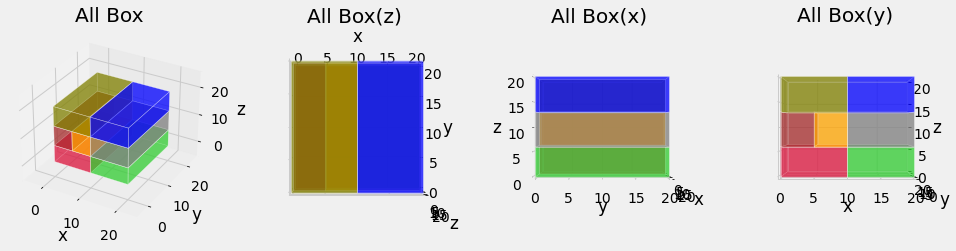

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


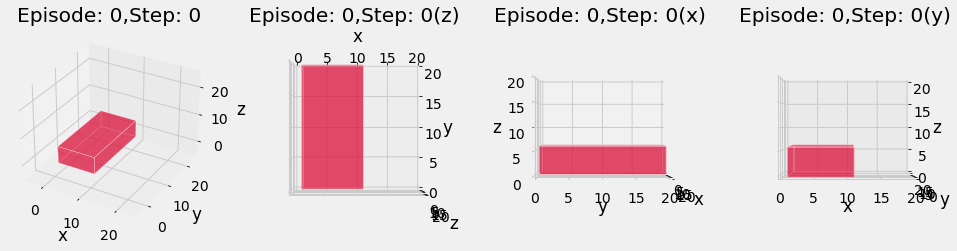

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


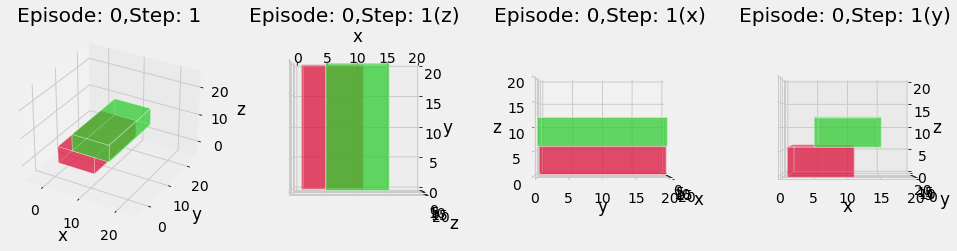

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


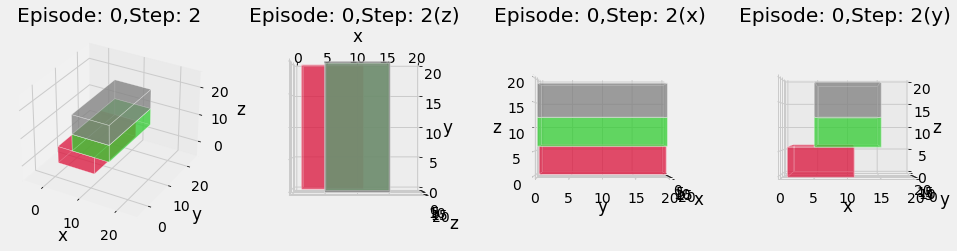

[[ 0  0]
 [15  0]]


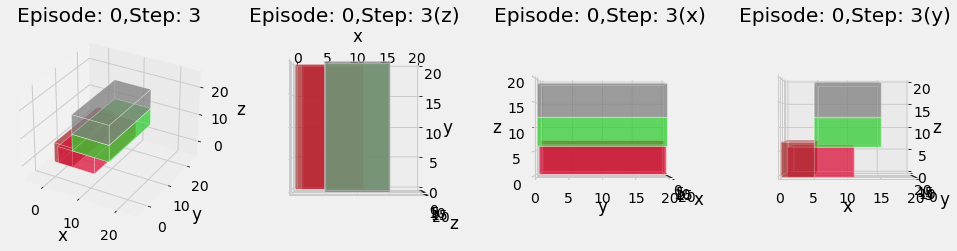

[[ 0  0]
 [15  0]]


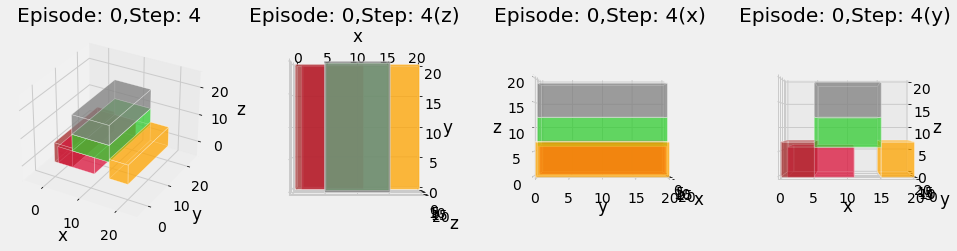

[]


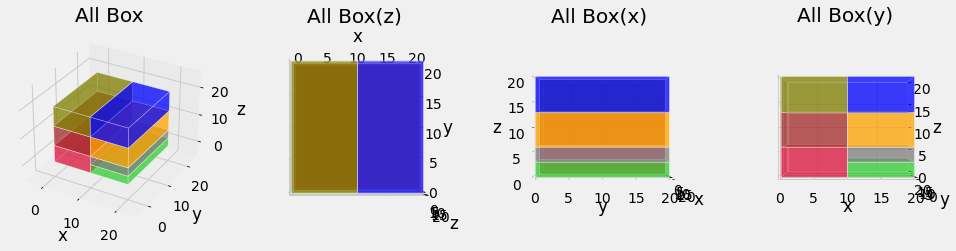

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


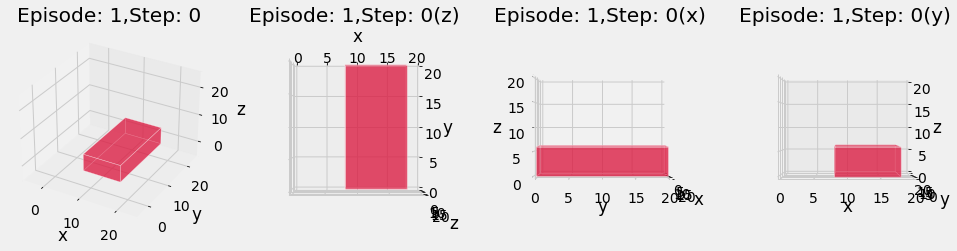

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


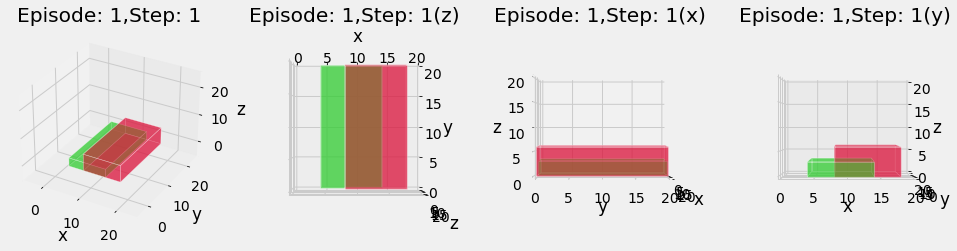

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


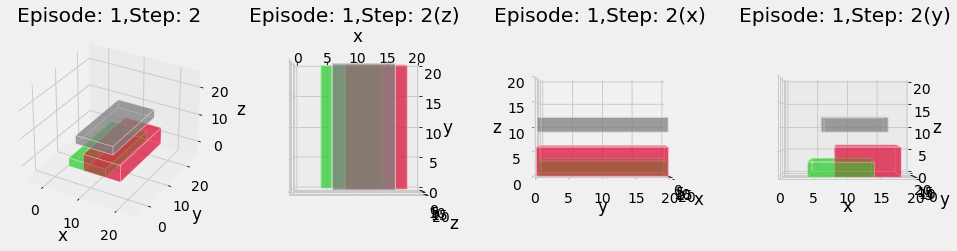

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


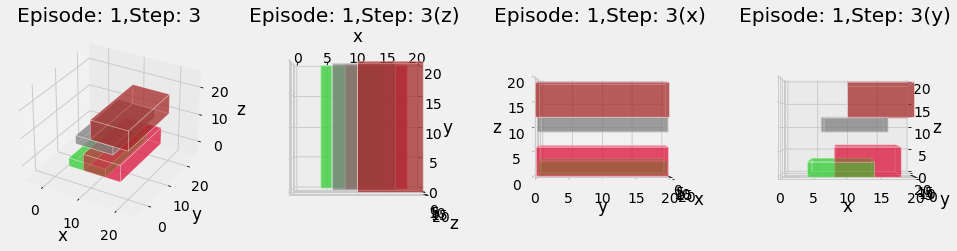

[[0 0]]


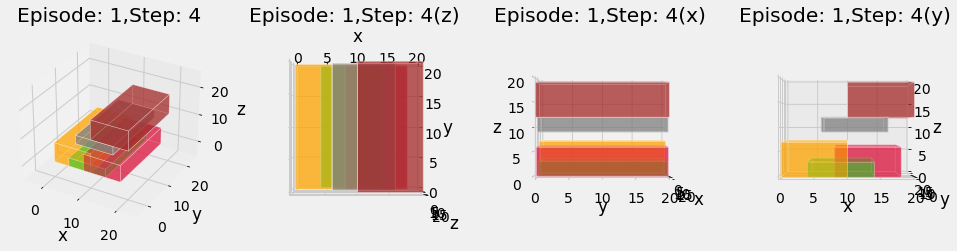

[]


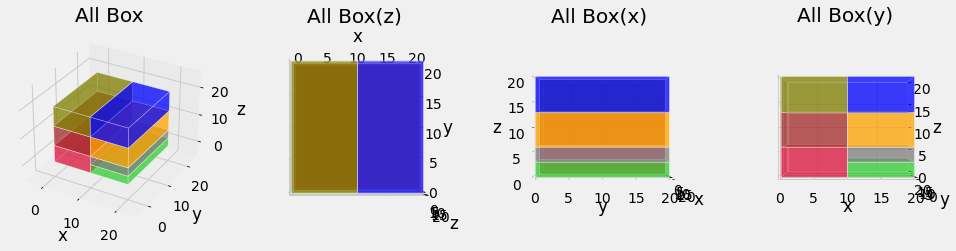

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


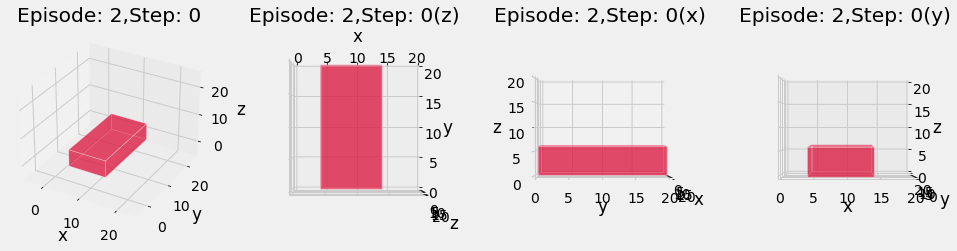

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


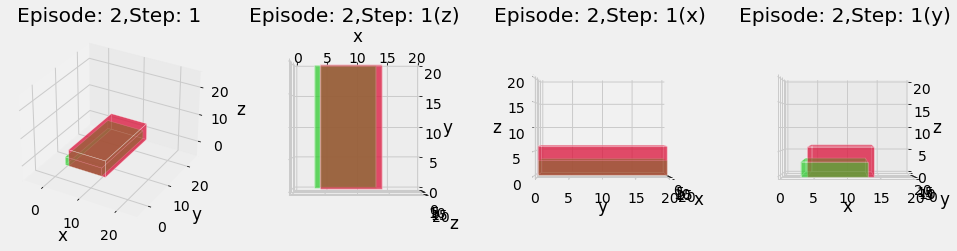

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


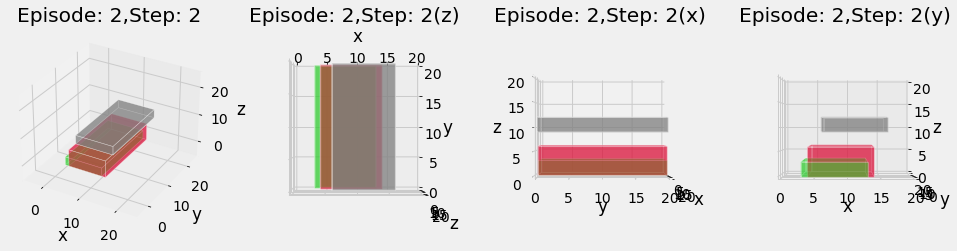

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


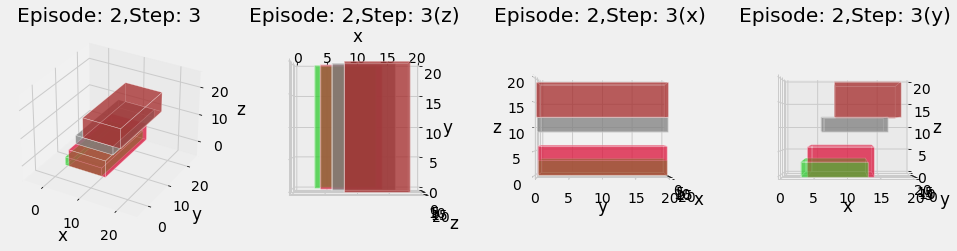

[]


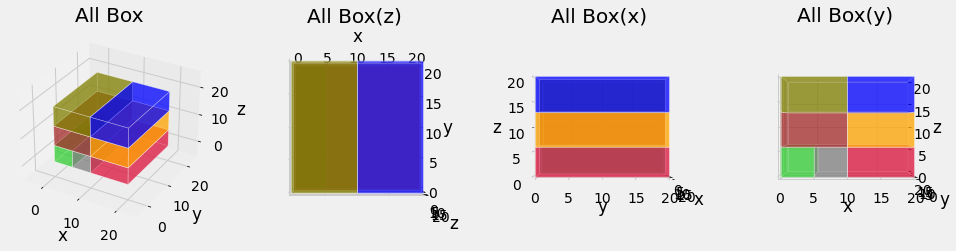

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


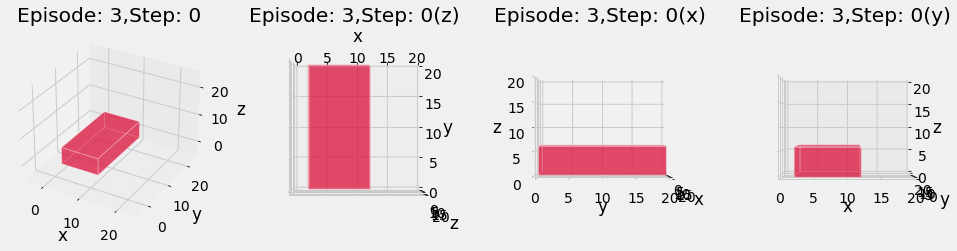

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]]


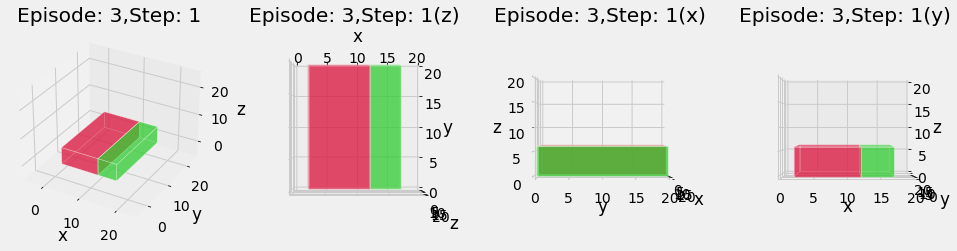

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]]


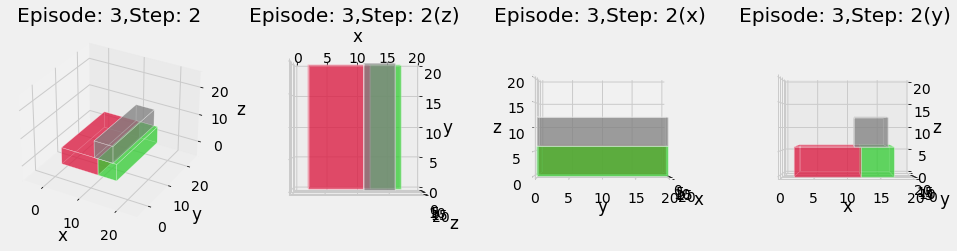

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


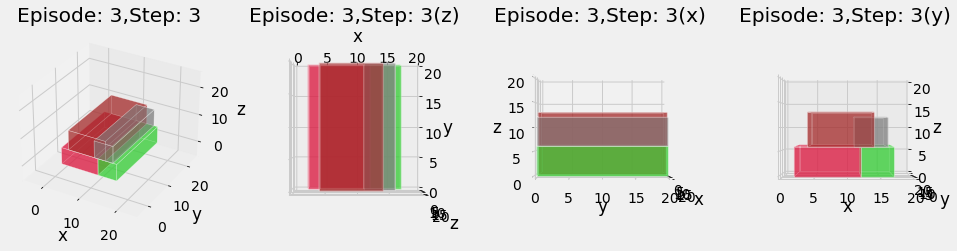

[]


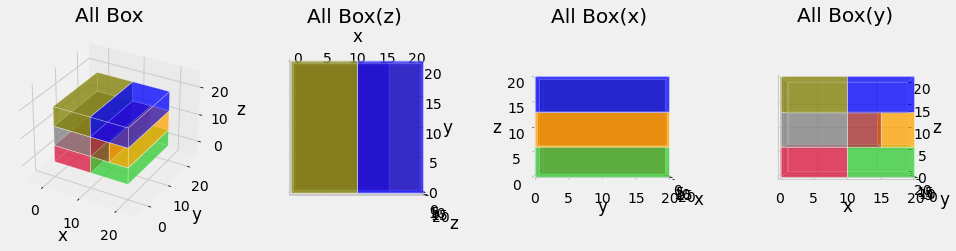

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


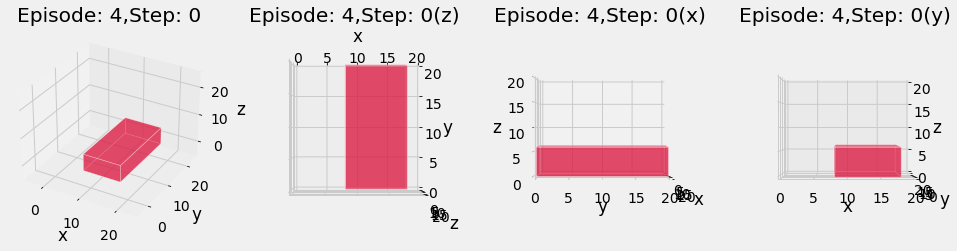

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


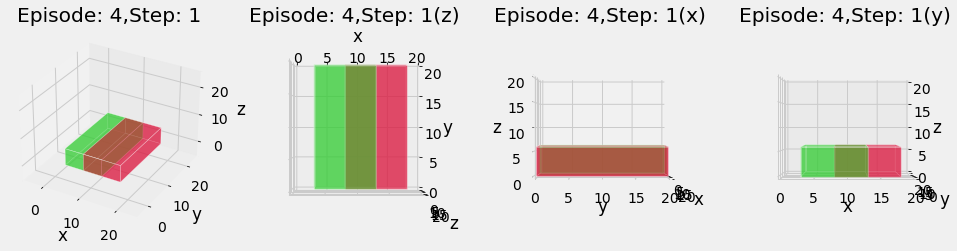

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


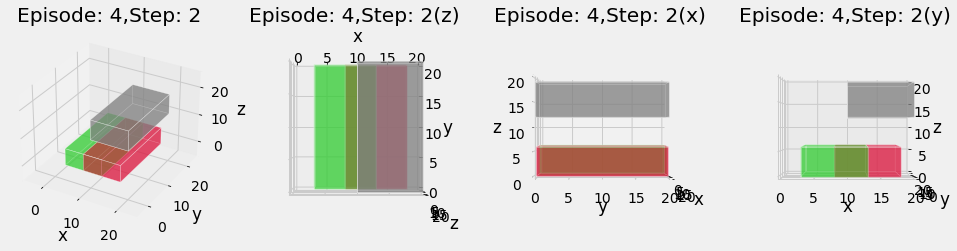

[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]]


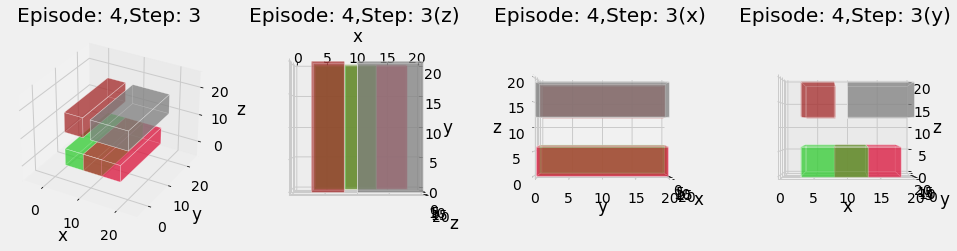

[]


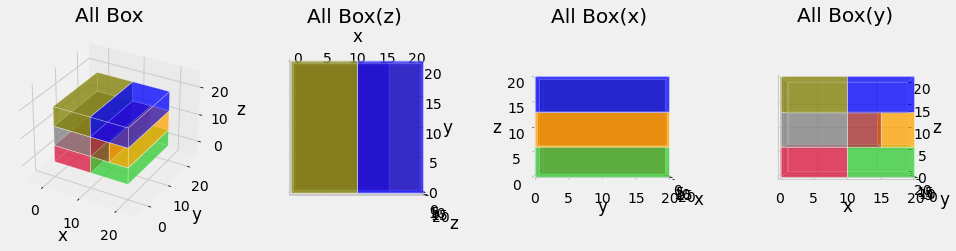

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


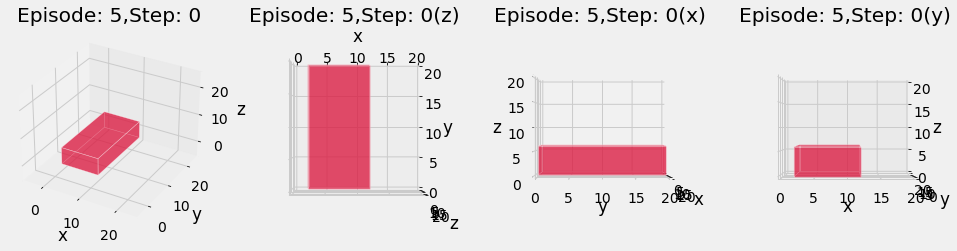

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


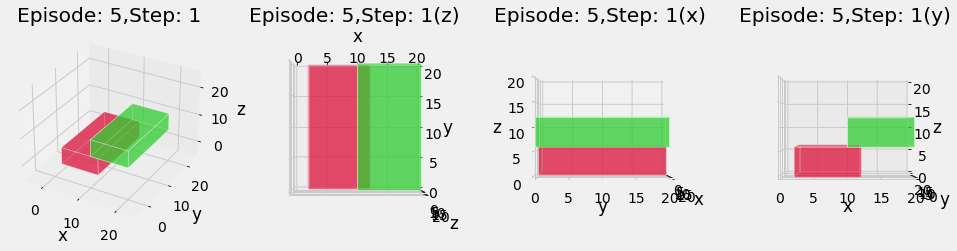

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


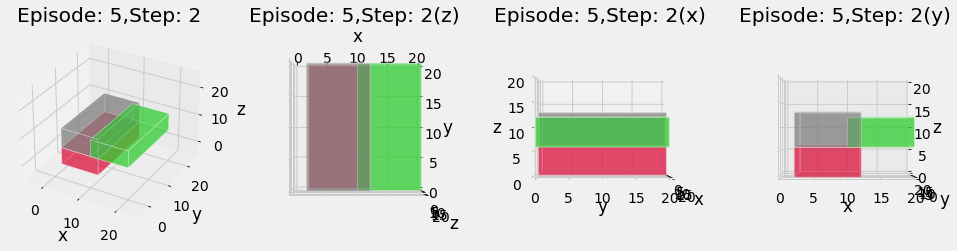

[[12  0]
 [13  0]
 [14  0]
 [15  0]]


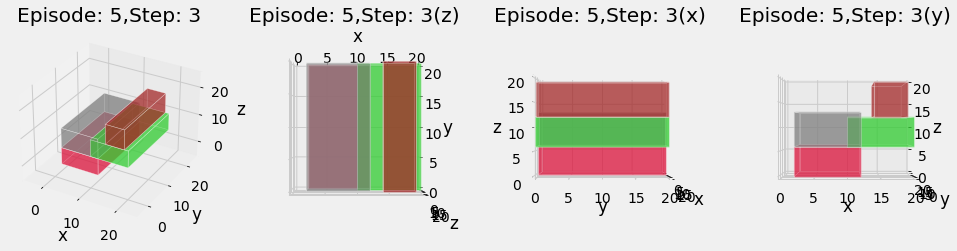

[]


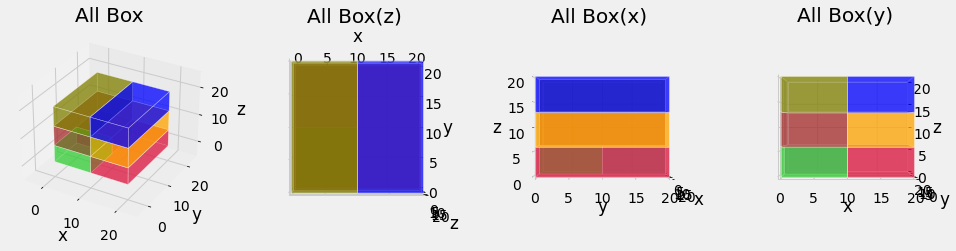

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


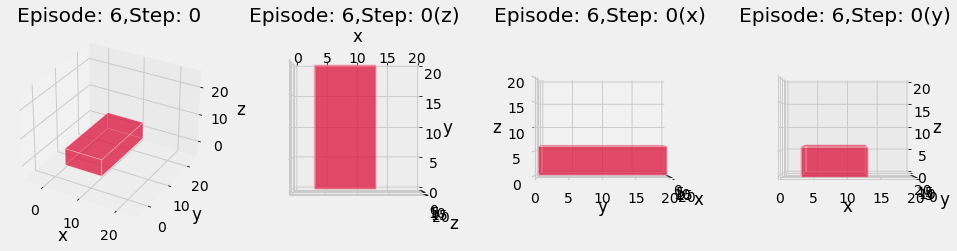

[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 2  0]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 3  0]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 4  6]
 [ 4  7]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 5  0]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 5  9]
 [ 5 10]
 [ 6  0]
 [ 6  1]
 [ 6  2]
 [ 6  3]
 [ 6  4]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 6  8]
 [ 6  9]
 [ 6 10]
 [ 7  0]
 [ 7  1]
 [ 7  2]
 [ 7  3]
 [ 7  4]
 [ 7  5]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 7  9]
 [ 7 10]
 [ 8  0]
 [ 8  1]
 [ 8  2]
 [ 8  3]
 [ 8  4]
 [ 8  5]
 [ 8  6]
 [ 8  7]
 [ 8  8]
 [ 8  9]
 [ 8 10]
 [ 9  0]
 [ 9  1]
 [ 9  2]
 [ 9  3]
 [ 9  4]
 [ 9  5]
 [ 9  6]
 [ 9  7]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [10  0]
 

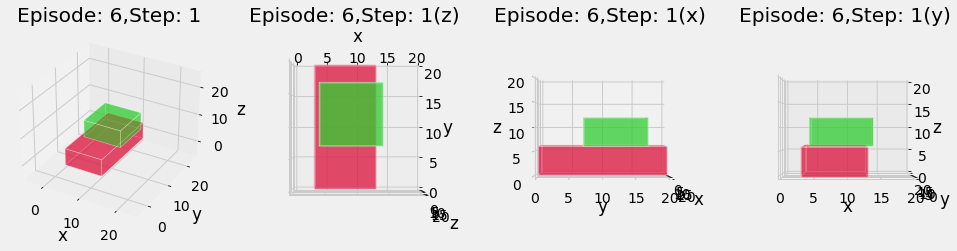

[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 2  0]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 3  0]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 4  6]
 [ 4  7]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 5  0]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 5  9]
 [ 5 10]
 [ 6  0]
 [ 6  1]
 [ 6  2]
 [ 6  3]
 [ 6  4]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 6  8]
 [ 6  9]
 [ 6 10]
 [ 7  0]
 [ 7  1]
 [ 7  2]
 [ 7  3]
 [ 7  4]
 [ 7  5]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 7  9]
 [ 7 10]
 [ 8  0]
 [ 8  1]
 [ 8  2]
 [ 8  3]
 [ 8  4]
 [ 8  5]
 [ 8  6]
 [ 8  7]
 [ 8  8]
 [ 8  9]
 [ 8 10]
 [ 9  0]
 [ 9  1]
 [ 9  2]
 [ 9  3]
 [ 9  4]
 [ 9  5]
 [ 9  6]
 [ 9  7]
 [ 9  8]
 [ 9  9]
 [ 9 10]
 [10  0]
 

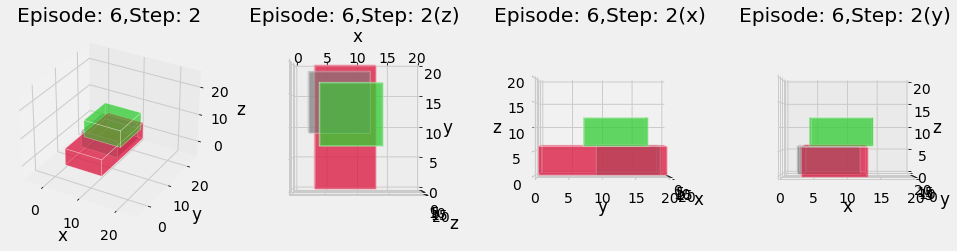

[]


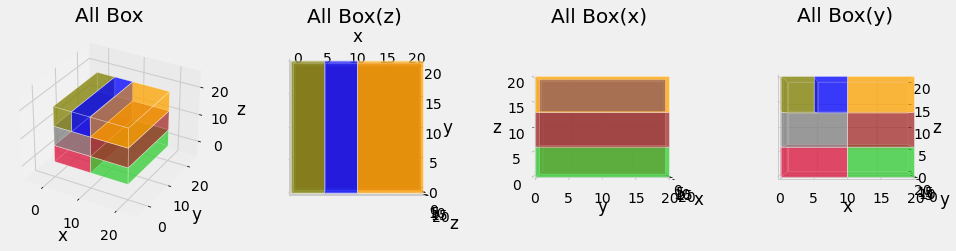

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


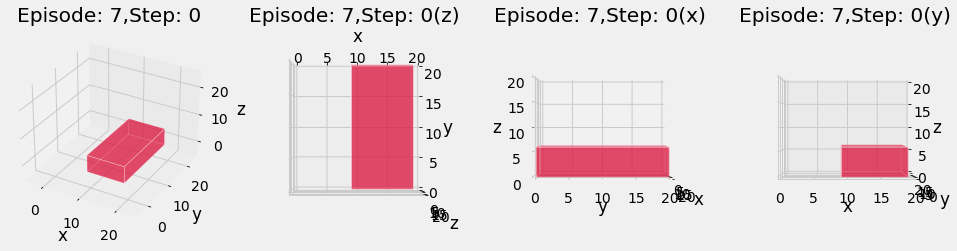

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


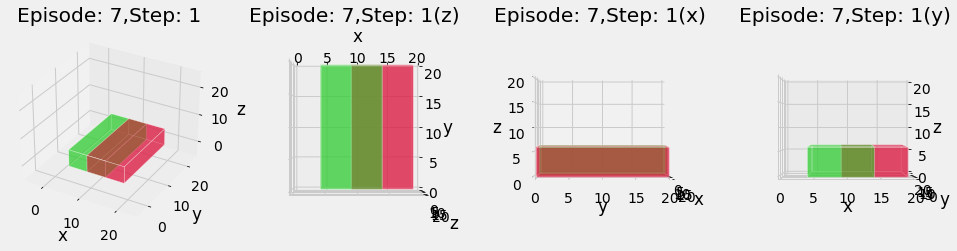

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


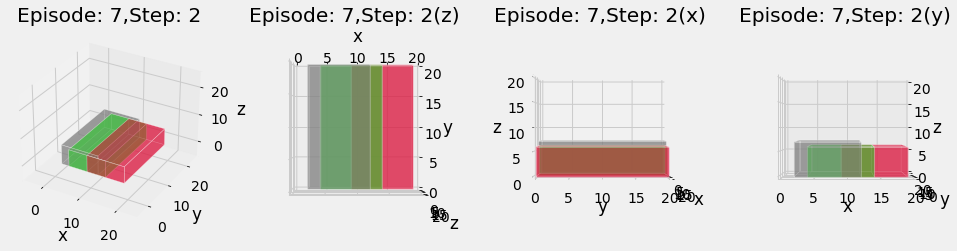

[]


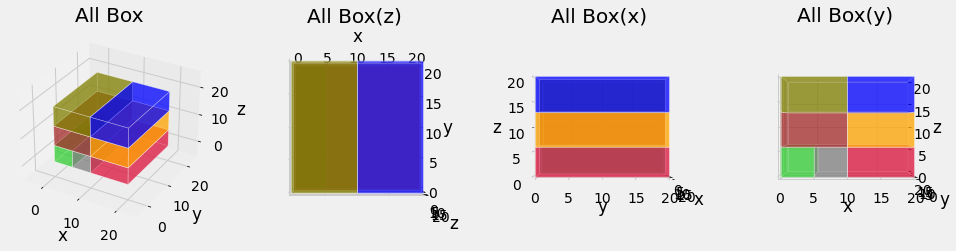

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


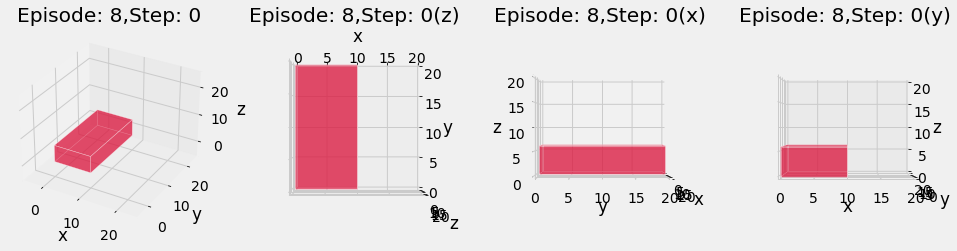

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]]


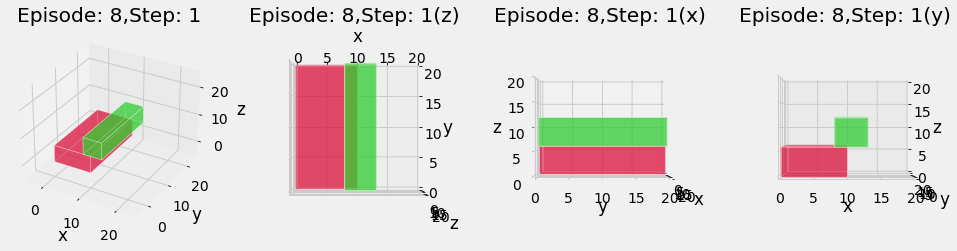

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]]


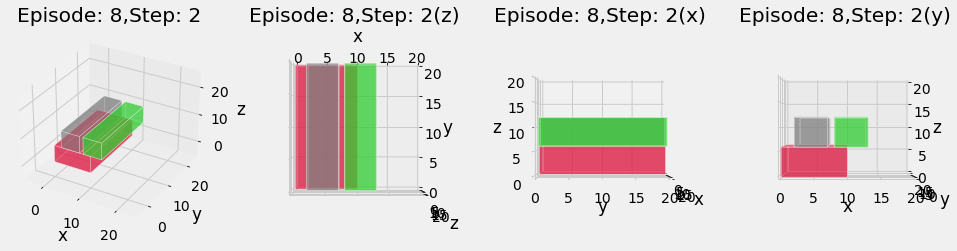

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


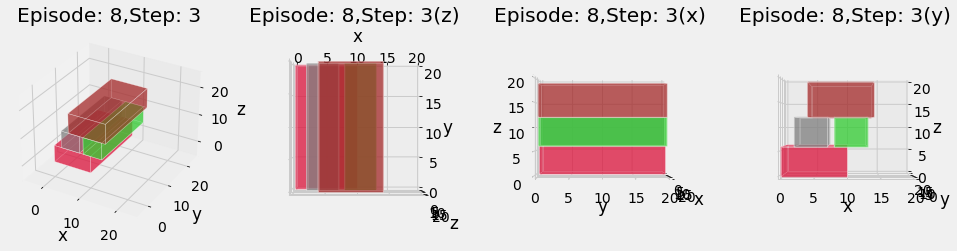

[]


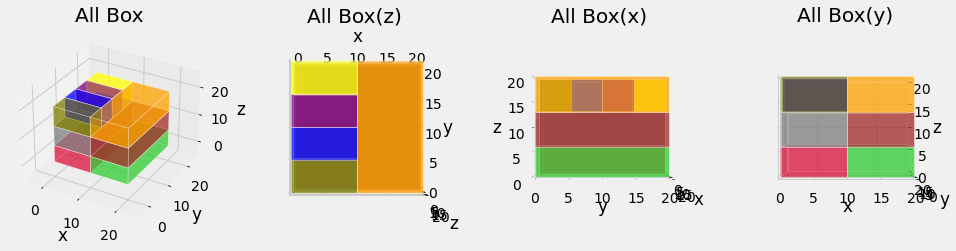

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


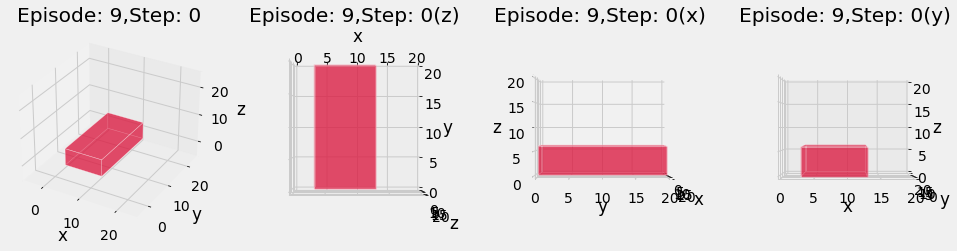

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


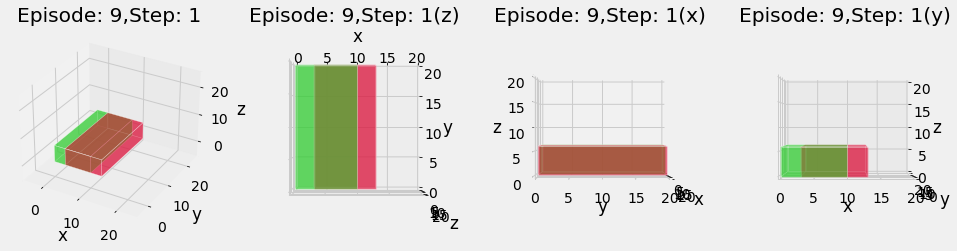

[[ 0  0]
 [ 1  0]
 [ 2  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 6  0]
 [ 7  0]
 [ 8  0]
 [ 9  0]
 [10  0]]


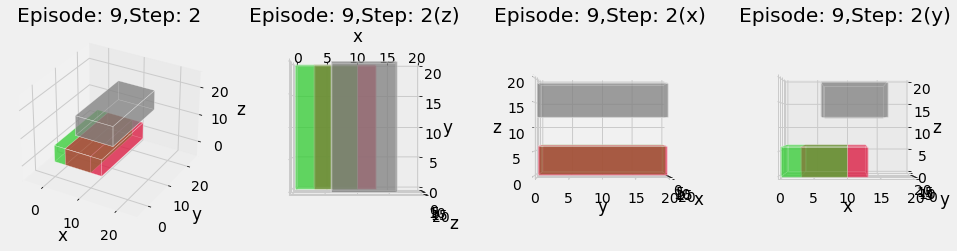

[]


In [23]:
EPISODES = 10

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 7

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
    boxes = boxes[0]
    gt_pos = gt_pos[0]
    
    box_list = []
    pos_list = []

    step = 0
    ax = vis_box(boxes, gt_pos, title='All Box')
    while not done:
        history = env.container_h.copy()
        box = boxes[step]
        #w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1
        
        #f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     #state_H = env.height, is2d=False)
        f_upleft = get_f_upleft(box, env)
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = random.randint(0, len(f_upleft)-1)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        print(f_upleft)
#         if len(f_upleft) == 0:
#             done = True
#             action = -1
#         else:
#             action = agent.get_action(state, len(f_upleft))
        #print(len(f_upleft), action)
        #########
        
#         if not done:
#             box_list.append(box)
#             upleft = f_upleft[action]
#             pos_list.append(np.array([f_upleft[action][0], f_upleft[action][1], 
#                            history[upleft[0]][upleft[1]]]))
#             vis_box(box_list, pos_list, 411, title='Episode: ' + str(episode)+',Step: ' + str(step-1))
#             next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
#             next_state = np.reshape(next_state, [1, state_size])

#             if step == len(boxes):
#                 done = True

#         #reward = reward if not done or score == 499 else -100

#         agent.train_model(state, action, reward, next_state, done)
#         score += reward

        if not done:
            box_list.append(box)
            upleft = f_upleft[action]
            pos_list.append(np.array([f_upleft[action][0], f_upleft[action][1], 
                           history[upleft[0]][upleft[1]]]))
            vis_box(box_list, pos_list, 411, title='Episode: ' + str(episode)+',Step: ' + str(step-1))
            env.step(f_upleft[action], box[0], box[1], box[2])
            if step == len(boxes):
                     done = True
        #state = next_state

#         if done:
#             frac_list.append(env.terminal_reward())
#             history_actor_list.append(agent.actor_history)
#             history_critic_list.append(agent.critic_history)

#             score = score if score == 500.0 else score + 100
            
#             log = 'Episode: ' + str(episode)
#             log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
#             log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
#             log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
#             print(log)

In [15]:
import pandas as pd

In [5]:
EPISODES = 1000

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 17

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
    boxes = boxes[0]

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        #print(len(f_upleft), action)
        #########
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                9624      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 24)                9624      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________
Episode: 0, Reward: 30.0%, Actor Loss: [3

Episode: 75, Reward: 22.5%, Actor Loss: [177.64801025390625], Critic Loss: [709.592041015625]
Episode: 76, Reward: 47.5%, Actor Loss: [204.6501922607422], Critic Loss: [817.6007690429688]
Episode: 77, Reward: 33.5%, Actor Loss: [176.61009216308594], Critic Loss: [705.4403686523438]
Episode: 78, Reward: 30.0%, Actor Loss: [1111.3526611328125], Critic Loss: [4444.41064453125]
Episode: 79, Reward: 65.0%, Actor Loss: [2589.07080078125], Critic Loss: [10355.283203125]
Episode: 80, Reward: 43.12%, Actor Loss: [230.270751953125], Critic Loss: [920.0830078125]
Episode: 81, Reward: 7.5%, Actor Loss: [1292.8289794921875], Critic Loss: [5170.31591796875]
Episode: 82, Reward: 30.0%, Actor Loss: [279.4962463378906], Critic Loss: [1116.9849853515625]
Episode: 83, Reward: 56.25%, Actor Loss: [987.2122192382812], Critic Loss: [3947.848876953125]
Episode: 84, Reward: 30.0%, Actor Loss: [44.63461685180664], Critic Loss: [177.53846740722656]
Episode: 85, Reward: 47.5%, Actor Loss: [362.26251220703125], C

Episode: 163, Reward: 8.25%, Actor Loss: [1072.322509765625], Critic Loss: [4288.61328125]
Episode: 164, Reward: 36.56%, Actor Loss: [44.78188705444336], Critic Loss: [178.12754821777344]
Episode: 165, Reward: 44.0%, Actor Loss: [92.27781677246094], Critic Loss: [368.11126708984375]
Episode: 166, Reward: 30.0%, Actor Loss: [0.30745625495910645], Critic Loss: [0.2298249751329422]
Episode: 167, Reward: 30.0%, Actor Loss: [1.0438584089279175], Critic Loss: [3.273136615753174]
Episode: 168, Reward: 12.0%, Actor Loss: [205.92193603515625], Critic Loss: [822.687744140625]
Episode: 169, Reward: 38.75%, Actor Loss: [88.9778823852539], Critic Loss: [354.9115295410156]
Episode: 170, Reward: 30.0%, Actor Loss: [27.254947662353516], Critic Loss: [108.01979064941406]
Episode: 171, Reward: 30.0%, Actor Loss: [56.78170394897461], Critic Loss: [226.12681579589844]
Episode: 172, Reward: 35.25%, Actor Loss: [73.60279846191406], Critic Loss: [293.41119384765625]
Episode: 173, Reward: 22.5%, Actor Loss: [

Episode: 250, Reward: 58.44%, Actor Loss: [17.08655548095703], Critic Loss: [67.34622192382812]
Episode: 251, Reward: 47.5%, Actor Loss: [13.712615013122559], Critic Loss: [53.850460052490234]
Episode: 252, Reward: 38.75%, Actor Loss: [556.493896484375], Critic Loss: [2224.9755859375]
Episode: 253, Reward: 37.0%, Actor Loss: [25.022743225097656], Critic Loss: [99.09097290039062]
Episode: 254, Reward: 30.0%, Actor Loss: [452.9315185546875], Critic Loss: [1810.72607421875]
Episode: 255, Reward: 22.5%, Actor Loss: [148.56784057617188], Critic Loss: [593.2713623046875]
Episode: 256, Reward: 30.0%, Actor Loss: [119.52394104003906], Critic Loss: [477.09576416015625]
Episode: 257, Reward: 22.5%, Actor Loss: [104.63098907470703], Critic Loss: [417.5239562988281]
Episode: 258, Reward: 45.75%, Actor Loss: [260.5380859375], Critic Loss: [1041.15234375]
Episode: 259, Reward: 45.31%, Actor Loss: [448.5066833496094], Critic Loss: [1793.0267333984375]
Episode: 260, Reward: 30.0%, Actor Loss: [69.9059

Episode: 336, Reward: 38.75%, Actor Loss: [222.09365844726562], Critic Loss: [887.3746337890625]
Episode: 337, Reward: 34.38%, Actor Loss: [24.734270095825195], Critic Loss: [97.93708038330078]
Episode: 338, Reward: 47.5%, Actor Loss: [294.5756530761719], Critic Loss: [1177.3026123046875]
Episode: 339, Reward: 22.5%, Actor Loss: [153.06007385253906], Critic Loss: [611.2402954101562]
Episode: 340, Reward: 22.5%, Actor Loss: [439.6063537597656], Critic Loss: [1757.4254150390625]
Episode: 341, Reward: 11.25%, Actor Loss: [1149.7415771484375], Critic Loss: [4597.96630859375]
Episode: 342, Reward: 60.62%, Actor Loss: [2693.716064453125], Critic Loss: [10773.8642578125]
Episode: 343, Reward: 30.0%, Actor Loss: [152.55384826660156], Critic Loss: [609.2153930664062]
Episode: 344, Reward: 38.75%, Actor Loss: [0.5224673748016357], Critic Loss: [1.0898696184158325]
Episode: 345, Reward: 40.94%, Actor Loss: [78.8795166015625], Critic Loss: [314.51806640625]
Episode: 346, Reward: 32.19%, Actor Loss

Episode: 422, Reward: 43.12%, Actor Loss: [230.5166473388672], Critic Loss: [869.7081298828125]
Episode: 423, Reward: 30.0%, Actor Loss: [462.2948913574219], Critic Loss: [1848.1795654296875]
Episode: 424, Reward: 47.5%, Actor Loss: [31.793153762817383], Critic Loss: [126.17261505126953]
Episode: 425, Reward: 22.5%, Actor Loss: [366.490478515625], Critic Loss: [1392.3291015625]
Episode: 426, Reward: 37.0%, Actor Loss: [30.470088958740234], Critic Loss: [120.88035583496094]
Episode: 427, Reward: 30.0%, Actor Loss: [13.869356155395508], Critic Loss: [54.47742462158203]
Episode: 428, Reward: 11.25%, Actor Loss: [1455.9383544921875], Critic Loss: [5822.75341796875]
Episode: 429, Reward: 26.25%, Actor Loss: [42.677425384521484], Critic Loss: [169.70970153808594]
Episode: 430, Reward: 22.5%, Actor Loss: [230.7455291748047], Critic Loss: [921.9821166992188]
Episode: 431, Reward: 38.75%, Actor Loss: [236.41920471191406], Critic Loss: [944.6768188476562]
Episode: 432, Reward: 37.0%, Actor Loss:

Episode: 509, Reward: 37.0%, Actor Loss: [435.6184997558594], Critic Loss: [1741.4739990234375]
Episode: 510, Reward: 35.25%, Actor Loss: [144.73829650878906], Critic Loss: [577.9531860351562]
Episode: 511, Reward: 30.0%, Actor Loss: [14.960582733154297], Critic Loss: [58.84233093261719]
Episode: 512, Reward: 38.75%, Actor Loss: [346.447265625], Critic Loss: [1384.7890625]
Episode: 513, Reward: 37.0%, Actor Loss: [922.1649780273438], Critic Loss: [3687.659912109375]
Episode: 514, Reward: 15.0%, Actor Loss: [263.4962463378906], Critic Loss: [1052.9849853515625]
Episode: 515, Reward: 22.5%, Actor Loss: [173.4099884033203], Critic Loss: [692.6399536132812]
Episode: 516, Reward: 40.94%, Actor Loss: [1378.81640625], Critic Loss: [5514.265625]
Episode: 517, Reward: 11.25%, Actor Loss: [756.6278076171875], Critic Loss: [3025.51123046875]
Episode: 518, Reward: 30.0%, Actor Loss: [75.31233978271484], Critic Loss: [300.2493591308594]
Episode: 519, Reward: 47.5%, Actor Loss: [1031.5225830078125],

Episode: 597, Reward: 22.5%, Actor Loss: [147.79257202148438], Critic Loss: [590.1716918945312]
Episode: 598, Reward: 34.38%, Actor Loss: [328.4136047363281], Critic Loss: [1312.68115234375]
Episode: 599, Reward: 38.75%, Actor Loss: [740.4264526367188], Critic Loss: [2960.705810546875]
Episode: 600, Reward: 38.75%, Actor Loss: [428.8614807128906], Critic Loss: [1714.4459228515625]
Episode: 601, Reward: 30.0%, Actor Loss: [100.28646850585938], Critic Loss: [400.1458740234375]
Episode: 602, Reward: 65.0%, Actor Loss: [4738.88525390625], Critic Loss: [18954.541015625]
Episode: 603, Reward: 22.5%, Actor Loss: [36.183013916015625], Critic Loss: [143.7320556640625]
Episode: 604, Reward: 5.62%, Actor Loss: [1017.9102172851562], Critic Loss: [4070.640869140625]
Episode: 605, Reward: 33.5%, Actor Loss: [292.73809814453125], Critic Loss: [1169.952392578125]
Episode: 606, Reward: 49.69%, Actor Loss: [177.34744262695312], Critic Loss: [708.3897705078125]
Episode: 607, Reward: 6.0%, Actor Loss: [73

Episode: 684, Reward: 6.0%, Actor Loss: [178.49635314941406], Critic Loss: [712.9924926757812]
Episode: 685, Reward: 22.5%, Actor Loss: [141.63623046875], Critic Loss: [565.544921875]
Episode: 686, Reward: 44.0%, Actor Loss: [1360.2767333984375], Critic Loss: [5440.10693359375]
Episode: 687, Reward: 11.25%, Actor Loss: [695.9596557617188], Critic Loss: [2782.838623046875]
Episode: 688, Reward: 22.5%, Actor Loss: [1665.27734375], Critic Loss: [6660.1123046875]
Episode: 689, Reward: 28.5%, Actor Loss: [0.407744824886322], Critic Loss: [0.6309792995452881]
Episode: 690, Reward: 65.0%, Actor Loss: [3373.635986328125], Critic Loss: [13493.5439453125]
Episode: 691, Reward: 30.0%, Actor Loss: [28.518028259277344], Critic Loss: [113.07211303710938]
Episode: 692, Reward: 33.5%, Actor Loss: [3462.061279296875], Critic Loss: [13847.2451171875]
Episode: 693, Reward: 15.0%, Actor Loss: [515.70654296875], Critic Loss: [2061.826171875]
Episode: 694, Reward: 43.12%, Actor Loss: [58.9903678894043], Cri

Episode: 771, Reward: 32.19%, Actor Loss: [381.9611511230469], Critic Loss: [1526.8446044921875]
Episode: 772, Reward: 34.38%, Actor Loss: [263.7167663574219], Critic Loss: [1053.8670654296875]
Episode: 773, Reward: 22.5%, Actor Loss: [549.9967041015625], Critic Loss: [2198.98681640625]
Episode: 774, Reward: 39.62%, Actor Loss: [660.218017578125], Critic Loss: [2639.8720703125]
Episode: 775, Reward: 12.0%, Actor Loss: [31.154029846191406], Critic Loss: [123.61611938476562]
Episode: 776, Reward: 30.0%, Actor Loss: [67.59308624267578], Critic Loss: [269.3723449707031]
Episode: 777, Reward: 15.0%, Actor Loss: [448.881103515625], Critic Loss: [1794.5244140625]
Episode: 778, Reward: 20.62%, Actor Loss: [53.37759780883789], Critic Loss: [212.51039123535156]
Episode: 779, Reward: 11.25%, Actor Loss: [543.2803955078125], Critic Loss: [2172.12158203125]
Episode: 780, Reward: 35.25%, Actor Loss: [392.5231018066406], Critic Loss: [1569.0924072265625]
Episode: 781, Reward: 30.0%, Actor Loss: [262.

Episode: 858, Reward: 43.12%, Actor Loss: [698.24853515625], Critic Loss: [2791.994140625]
Episode: 859, Reward: 43.12%, Actor Loss: [130.4657745361328], Critic Loss: [520.8630981445312]
Episode: 860, Reward: 35.25%, Actor Loss: [49.56211853027344], Critic Loss: [197.24847412109375]
Episode: 861, Reward: 12.0%, Actor Loss: [53.93425369262695], Critic Loss: [214.7370147705078]
Episode: 862, Reward: 54.5%, Actor Loss: [2025.2706298828125], Critic Loss: [8100.08251953125]
Episode: 863, Reward: 15.0%, Actor Loss: [532.43359375], Critic Loss: [2128.734375]
Episode: 864, Reward: 44.0%, Actor Loss: [445.1155090332031], Critic Loss: [1779.4620361328125]
Episode: 865, Reward: 56.25%, Actor Loss: [1124.6766357421875], Critic Loss: [4497.70654296875]
Episode: 866, Reward: 34.38%, Actor Loss: [90.35025024414062], Critic Loss: [360.4010009765625]
Episode: 867, Reward: 30.0%, Actor Loss: [294.93243408203125], Critic Loss: [1178.729736328125]
Episode: 868, Reward: 3.75%, Actor Loss: [824.997131347656

Episode: 945, Reward: 38.75%, Actor Loss: [50.21844482421875], Critic Loss: [199.873779296875]
Episode: 946, Reward: 8.44%, Actor Loss: [1008.5285034179688], Critic Loss: [4032.98291015625]
Episode: 947, Reward: 30.0%, Actor Loss: [74.67247772216797], Critic Loss: [297.6899108886719]
Episode: 948, Reward: 49.69%, Actor Loss: [625.642578125], Critic Loss: [2501.5703125]
Episode: 949, Reward: 18.75%, Actor Loss: [121.94361114501953], Critic Loss: [486.7744445800781]
Episode: 950, Reward: 58.0%, Actor Loss: [1086.82080078125], Critic Loss: [4346.283203125]
Episode: 951, Reward: 6.75%, Actor Loss: [428.4550476074219], Critic Loss: [1712.78564453125]
Episode: 952, Reward: 13.5%, Actor Loss: [191.135498046875], Critic Loss: [763.5419921875]
Episode: 953, Reward: 11.25%, Actor Loss: [303.86810302734375], Critic Loss: [1214.472412109375]
Episode: 954, Reward: 22.5%, Actor Loss: [139.92337036132812], Critic Loss: [558.6951904296875]
Episode: 955, Reward: 46.19%, Actor Loss: [453.6827697753906],

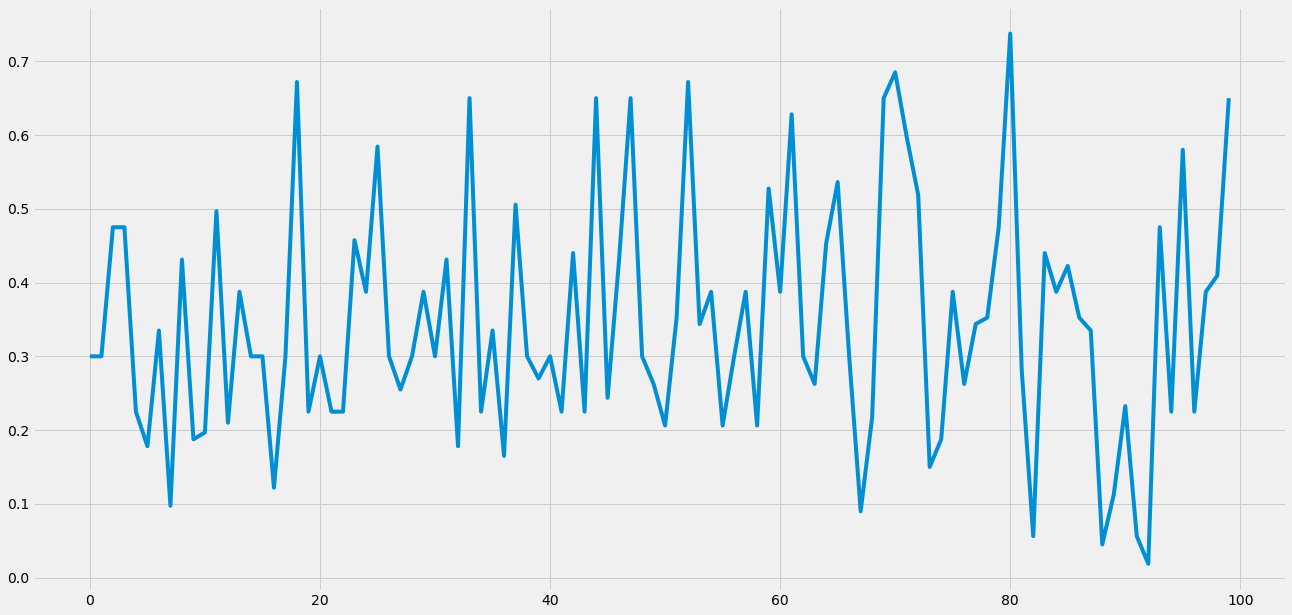

In [6]:
plt.plot(frac_list[::10])

In [7]:
actor_loss_list, critic_loss_list = [], []
for a_history, c_history in zip(history_actor_list, history_critic_list):
    actor_loss_list.append(a_history.history['loss'][-1])
    critic_loss_list.append(c_history.history['loss'][-1])

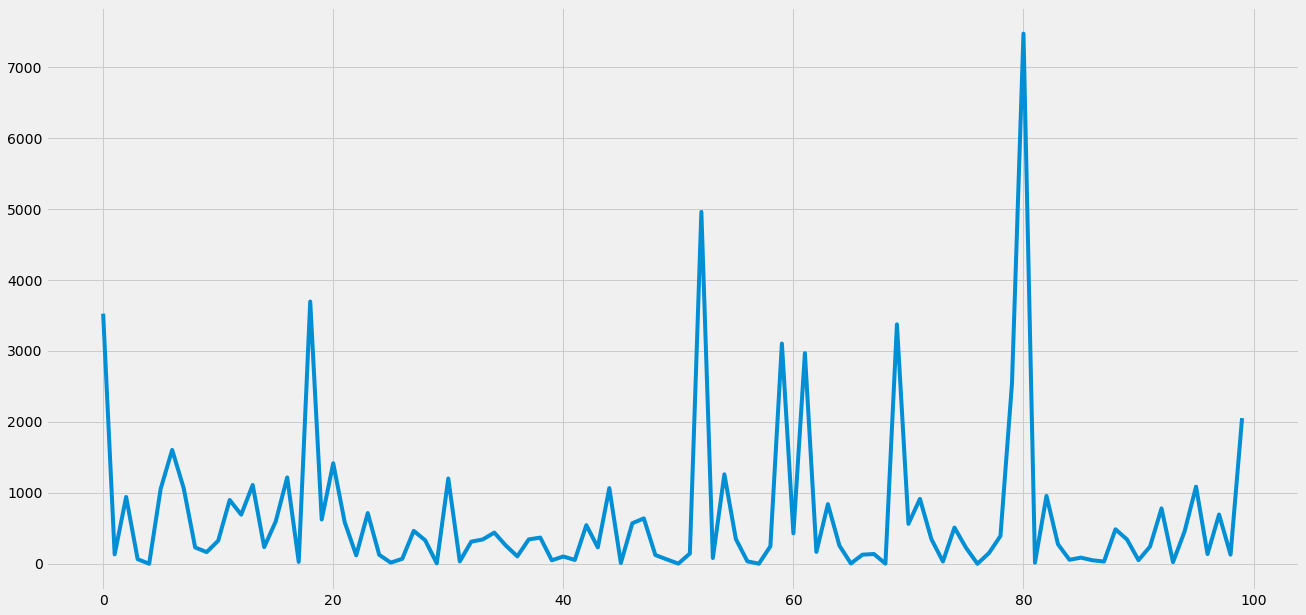

In [8]:
plt.plot(actor_loss_list[::10])

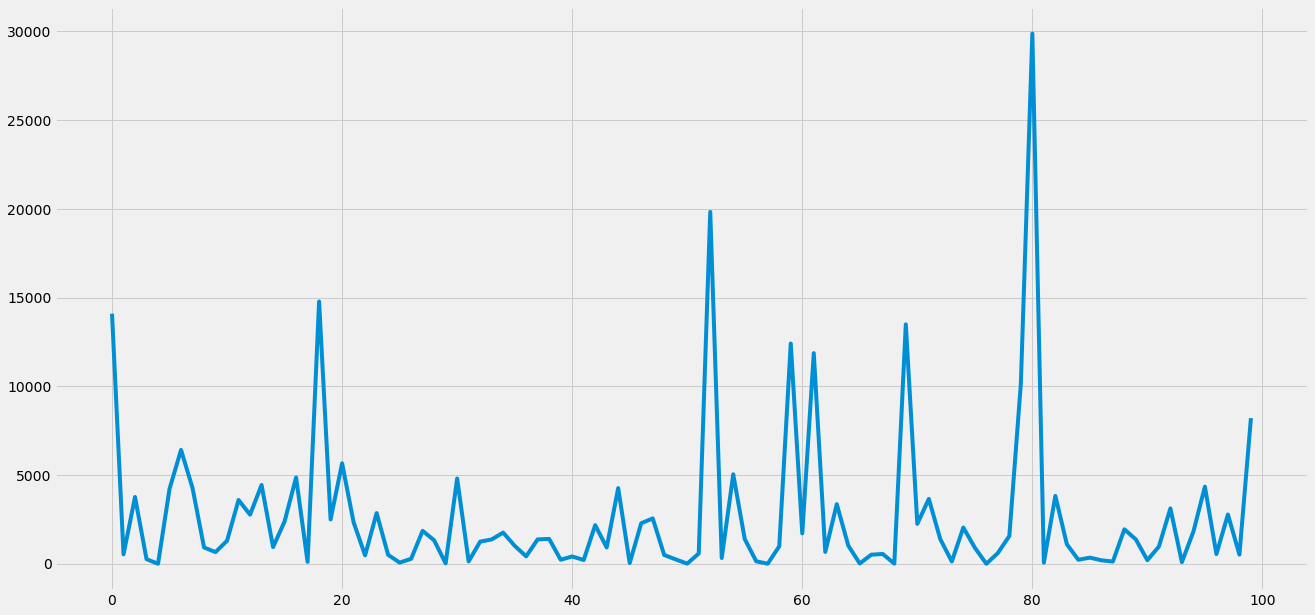

In [9]:
plt.plot(critic_loss_list[::10])

In [111]:
EPISODES = 1000

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 17

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
    boxes = boxes[0]

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        #print(len(f_upleft), action)
        #########
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_141 (Dense)            (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_143 (Dense)            (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________
Episode: 0, Reward: 33.5%, Actor Loss: [-

Episode: 84, Reward: 38.75%, Actor Loss: [0.0], Critic Loss: [12802.0615234375]
Episode: 85, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [564.0795288085938]
Episode: 86, Reward: 56.25%, Actor Loss: [0.0], Critic Loss: [4520.34423828125]
Episode: 87, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [855.2108154296875]
Episode: 88, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [2496.9072265625]
Episode: 89, Reward: 38.75%, Actor Loss: [0.0], Critic Loss: [2338.703369140625]
Episode: 90, Reward: 37.0%, Actor Loss: [0.0], Critic Loss: [306.9123229980469]
Episode: 91, Reward: 72.0%, Actor Loss: [0.0], Critic Loss: [67341.359375]
Episode: 92, Reward: 20.62%, Actor Loss: [0.0], Critic Loss: [3858.185791015625]
Episode: 93, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [68.01856994628906]
Episode: 94, Reward: 22.5%, Actor Loss: [0.0], Critic Loss: [1356.791259765625]
Episode: 95, Reward: 21.75%, Actor Loss: [0.0], Critic Loss: [4270.10888671875]
Episode: 96, Reward: 26.25%, Actor Loss: [0.0

Episode: 186, Reward: 43.12%, Actor Loss: [0.0], Critic Loss: [10508.2900390625]
Episode: 187, Reward: 11.25%, Actor Loss: [0.0], Critic Loss: [2223.6494140625]
Episode: 188, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [9655.1826171875]
Episode: 189, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [288.4977722167969]
Episode: 190, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [1030.0557861328125]
Episode: 191, Reward: 69.38%, Actor Loss: [0.0], Critic Loss: [53154.30859375]
Episode: 192, Reward: 40.5%, Actor Loss: [0.0], Critic Loss: [94.90888214111328]
Episode: 193, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [579.8310546875]
Episode: 194, Reward: 15.0%, Actor Loss: [0.0], Critic Loss: [4477.4755859375]
Episode: 195, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [1248.1864013671875]
Episode: 196, Reward: 8.44%, Actor Loss: [0.0], Critic Loss: [7201.255859375]
Episode: 197, Reward: 20.62%, Actor Loss: [0.0], Critic Loss: [2781.182373046875]
Episode: 198, Reward: 51.88%, Actor Lo

Episode: 287, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [1239.0247802734375]
Episode: 288, Reward: 37.0%, Actor Loss: [0.0], Critic Loss: [75.51799774169922]
Episode: 289, Reward: 11.25%, Actor Loss: [-674.8426513671875], Critic Loss: [2025.7083740234375]
Episode: 290, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [8432.6142578125]
Episode: 291, Reward: 18.75%, Actor Loss: [-1142.0999755859375], Critic Loss: [2113.74462890625]
Episode: 292, Reward: 9.0%, Actor Loss: [0.0], Critic Loss: [3331.4892578125]
Episode: 293, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [100.26873779296875]
Episode: 294, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [2970.604248046875]
Episode: 295, Reward: 66.75%, Actor Loss: [0.0], Critic Loss: [38999.4765625]
Episode: 296, Reward: 38.75%, Actor Loss: [0.0], Critic Loss: [264.23883056640625]
Episode: 297, Reward: 44.0%, Actor Loss: [0.0], Critic Loss: [2.2935822010040283]
Episode: 298, Reward: 38.75%, Actor Loss: [0.0], Critic Loss: [420.831695556640

Episode: 387, Reward: 20.25%, Actor Loss: [0.0], Critic Loss: [39.67398452758789]
Episode: 388, Reward: 38.75%, Actor Loss: [0.0], Critic Loss: [460.5132141113281]
Episode: 389, Reward: 3.0%, Actor Loss: [0.0], Critic Loss: [5881.87841796875]
Episode: 390, Reward: 22.5%, Actor Loss: [0.0], Critic Loss: [313.6702880859375]
Episode: 391, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [1623.5048828125]
Episode: 392, Reward: 3.75%, Actor Loss: [0.0], Critic Loss: [4765.943359375]
Episode: 393, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [2154.484375]
Episode: 394, Reward: 38.75%, Actor Loss: [0.0], Critic Loss: [1499.1416015625]
Episode: 395, Reward: 13.12%, Actor Loss: [0.0], Critic Loss: [290.240478515625]
Episode: 396, Reward: 12.0%, Actor Loss: [397.2341613769531], Critic Loss: [87.30323791503906]
Episode: 397, Reward: 28.12%, Actor Loss: [0.0], Critic Loss: [5177.126953125]
Episode: 398, Reward: 15.0%, Actor Loss: [0.0], Critic Loss: [2901.56787109375]
Episode: 399, Reward: 30.0%, 

Episode: 489, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [3474.952880859375]
Episode: 490, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [7179.26806640625]
Episode: 491, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [3254.570556640625]
Episode: 492, Reward: 51.88%, Actor Loss: [0.0], Critic Loss: [5441.189453125]
Episode: 493, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [207.5912628173828]
Episode: 494, Reward: 52.75%, Actor Loss: [0.0], Critic Loss: [4716.30859375]
Episode: 495, Reward: 43.12%, Actor Loss: [0.0], Critic Loss: [2633.7275390625]
Episode: 496, Reward: 22.5%, Actor Loss: [0.0], Critic Loss: [71.78112030029297]
Episode: 497, Reward: 28.12%, Actor Loss: [0.0], Critic Loss: [21.833402633666992]
Episode: 498, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [195.64170837402344]
Episode: 499, Reward: 38.75%, Actor Loss: [0.0], Critic Loss: [1086.647705078125]
Episode: 500, Reward: 21.56%, Actor Loss: [0.0], Critic Loss: [74.80747985839844]
Episode: 501, Reward: 32.19%, 

Episode: 591, Reward: 38.75%, Actor Loss: [0.0], Critic Loss: [125.54847717285156]
Episode: 592, Reward: 25.5%, Actor Loss: [0.0], Critic Loss: [2155.666259765625]
Episode: 593, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [55.40723419189453]
Episode: 594, Reward: 68.5%, Actor Loss: [0.0], Critic Loss: [18928.875]
Episode: 595, Reward: 44.0%, Actor Loss: [0.0], Critic Loss: [1331.375732421875]
Episode: 596, Reward: 22.5%, Actor Loss: [0.0], Critic Loss: [183.8516082763672]
Episode: 597, Reward: 22.5%, Actor Loss: [0.0], Critic Loss: [1238.426513671875]
Episode: 598, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [487.31591796875]
Episode: 599, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [75.66047668457031]
Episode: 600, Reward: 18.75%, Actor Loss: [0.0], Critic Loss: [0.4363705515861511]
Episode: 601, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [834.342041015625]
Episode: 602, Reward: 40.94%, Actor Loss: [0.0], Critic Loss: [1100.0513916015625]
Episode: 603, Reward: 68.5%, Acto

Episode: 693, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [40.0146598815918]
Episode: 694, Reward: 38.75%, Actor Loss: [0.0], Critic Loss: [533.903564453125]
Episode: 695, Reward: 32.19%, Actor Loss: [0.0], Critic Loss: [18.385520935058594]
Episode: 696, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [604.679931640625]
Episode: 697, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [900.128173828125]
Episode: 698, Reward: 22.5%, Actor Loss: [0.0], Critic Loss: [18.962465286254883]
Episode: 699, Reward: 22.5%, Actor Loss: [0.0], Critic Loss: [88.54802703857422]
Episode: 700, Reward: 56.25%, Actor Loss: [0.0], Critic Loss: [6360.76611328125]
Episode: 701, Reward: 35.25%, Actor Loss: [0.0], Critic Loss: [1464.642333984375]
Episode: 702, Reward: 22.5%, Actor Loss: [0.0], Critic Loss: [229.09092712402344]
Episode: 703, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [24134.302734375]
Episode: 704, Reward: 48.38%, Actor Loss: [0.0], Critic Loss: [645.6768188476562]
Episode: 705, Reward: 56.25

Episode: 794, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [255.88380432128906]
Episode: 795, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [641.9027709960938]
Episode: 796, Reward: 20.62%, Actor Loss: [0.0], Critic Loss: [1599.3507080078125]
Episode: 797, Reward: 24.38%, Actor Loss: [0.0], Critic Loss: [7.646824836730957]
Episode: 798, Reward: 26.25%, Actor Loss: [0.0], Critic Loss: [737.822021484375]
Episode: 799, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [2411.21826171875]
Episode: 800, Reward: 12.0%, Actor Loss: [0.0], Critic Loss: [724.6517944335938]
Episode: 801, Reward: 26.25%, Actor Loss: [0.0], Critic Loss: [35.024070739746094]
Episode: 802, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [914.8870849609375]
Episode: 803, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [122.57546997070312]
Episode: 804, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [19844.126953125]
Episode: 805, Reward: 7.5%, Actor Loss: [0.0], Critic Loss: [3834.48486328125]
Episode: 806, Reward: 15.0

Episode: 896, Reward: 37.0%, Actor Loss: [0.0], Critic Loss: [150.61610412597656]
Episode: 897, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [20.80854034423828]
Episode: 898, Reward: 25.5%, Actor Loss: [0.0], Critic Loss: [597.7620849609375]
Episode: 899, Reward: 54.5%, Actor Loss: [0.0], Critic Loss: [3631.6015625]
Episode: 900, Reward: 33.5%, Actor Loss: [0.0], Critic Loss: [874.9395141601562]
Episode: 901, Reward: 14.25%, Actor Loss: [0.0], Critic Loss: [1155.845458984375]
Episode: 902, Reward: 34.38%, Actor Loss: [0.0], Critic Loss: [271.67877197265625]
Episode: 903, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [654.7589111328125]
Episode: 904, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [1318.958984375]
Episode: 905, Reward: 22.5%, Actor Loss: [0.0], Critic Loss: [1487.8485107421875]
Episode: 906, Reward: 22.5%, Actor Loss: [0.0], Critic Loss: [91.187255859375]
Episode: 907, Reward: 26.25%, Actor Loss: [0.0], Critic Loss: [47.8748664855957]
Episode: 908, Reward: 40.5%, Acto

Episode: 997, Reward: 36.56%, Actor Loss: [0.0], Critic Loss: [581.5879516601562]
Episode: 998, Reward: 12.19%, Actor Loss: [0.0], Critic Loss: [1680.6728515625]
Episode: 999, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [8668.236328125]


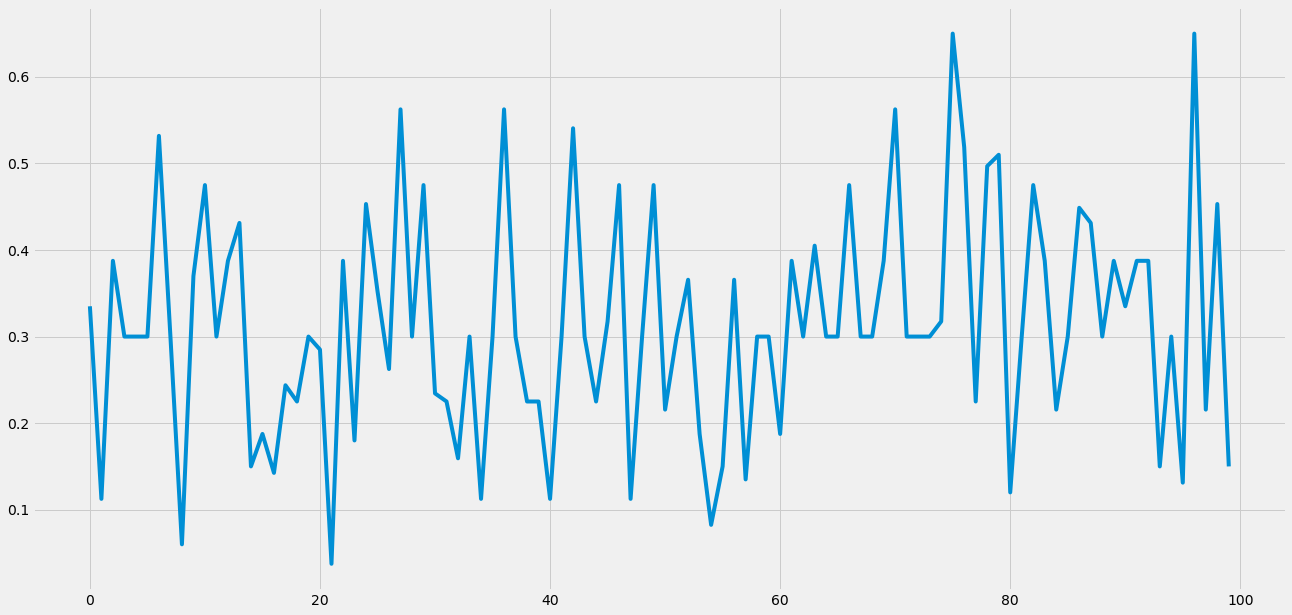

In [114]:
plt.plot(frac_list[::10])

In [123]:
actor_loss_list, critic_loss_list = [], []
for a_history, c_history in zip(history_actor_list, history_critic_list):
    actor_loss_list.append(a_history.history['loss'][-1])
    critic_loss_list.append(c_history.history['loss'][-1])

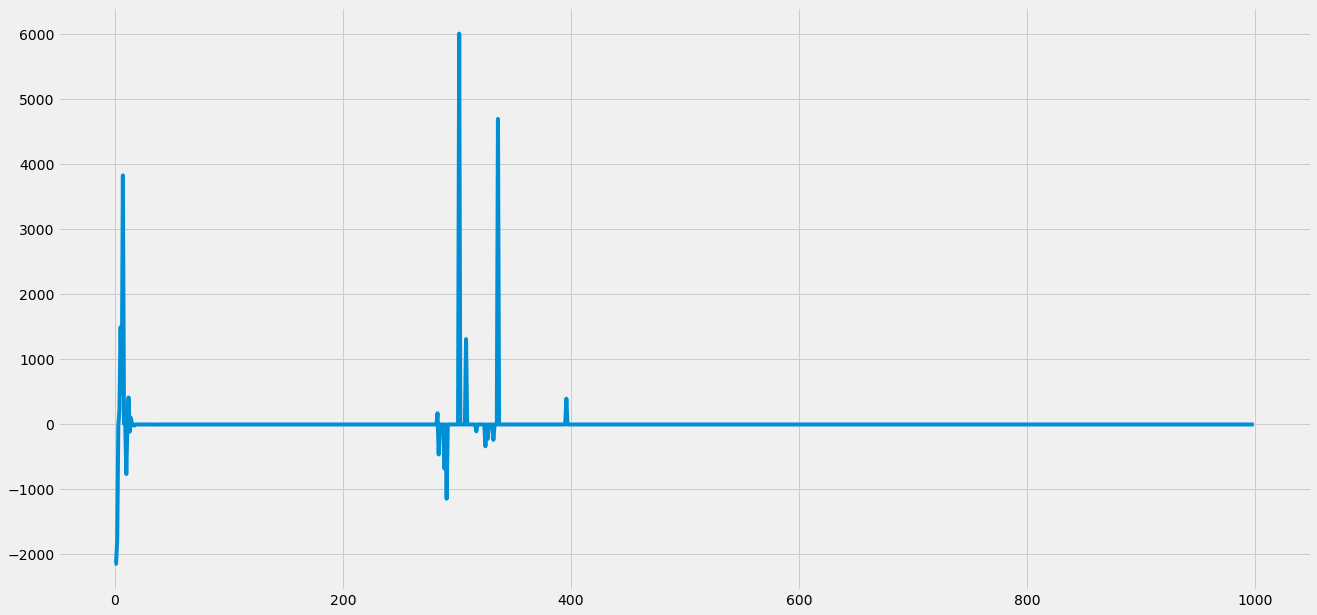

In [124]:
plt.plot(actor_loss_list)

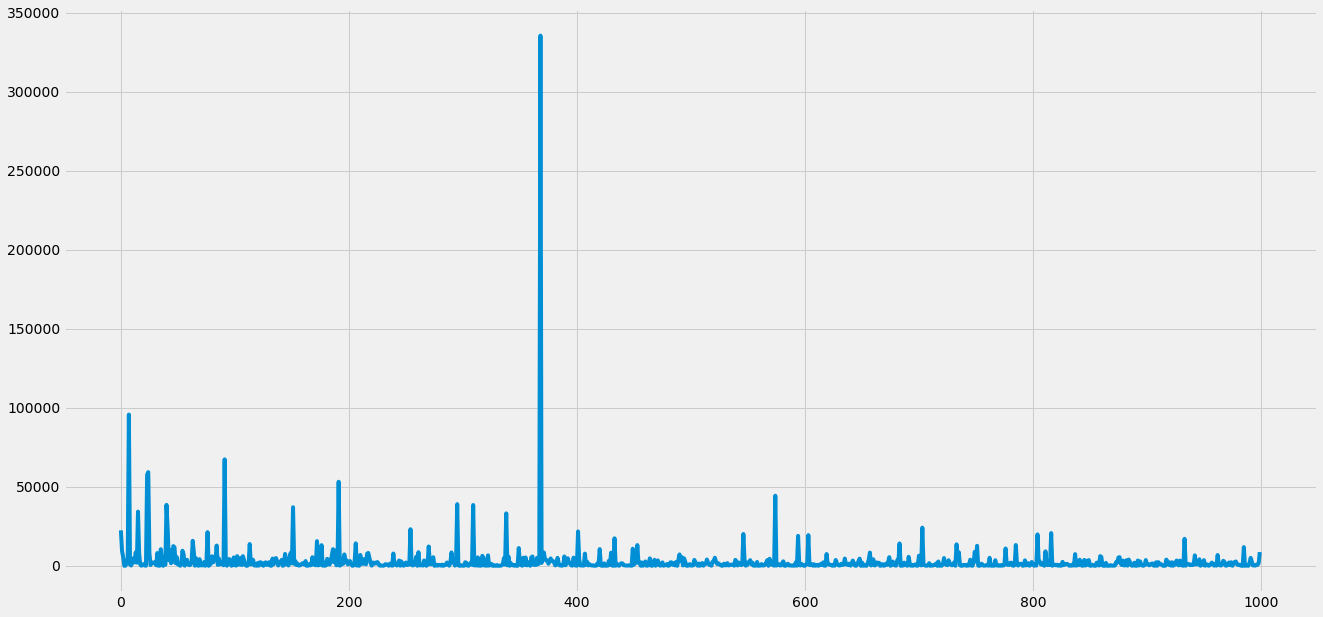

In [125]:
plt.plot(critic_loss_list)

In [127]:
EPISODES = 1000

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []
actions_list = []

N_MDD = 17
boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
boxes = boxes[0]

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()

    step = 0
    action_list = []
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        action_list.append(action)
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)
            actions_list.append(action_list)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            log += '\nAction: ' + str(action_list)
            
            print(log)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_149 (Dense)            (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________
Episode: 0, Reward: 21.0%, Actor Loss: [-

KeyboardInterrupt: 

In [128]:
EPISODES = 1000

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 17
boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
boxes = boxes[0]

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    np.random.shuffle(boxes)

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_153 (Dense)            (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________
Episode: 0, Reward: 5.5%, Actor Loss: [-4

Episode: 83, Reward: 38.75%, Actor Loss: [0.0], Critic Loss: [576.8726196289062]
Episode: 84, Reward: 21.62%, Actor Loss: [0.0], Critic Loss: [110.05365753173828]
Episode: 85, Reward: 41.0%, Actor Loss: [0.0], Critic Loss: [604.3295288085938]
Episode: 86, Reward: 14.12%, Actor Loss: [0.0], Critic Loss: [4420.37109375]
Episode: 87, Reward: 7.12%, Actor Loss: [0.0], Critic Loss: [7074.0185546875]
Episode: 88, Reward: 14.0%, Actor Loss: [0.0], Critic Loss: [2599.6484375]
Episode: 89, Reward: 9.25%, Actor Loss: [0.0], Critic Loss: [2360.206787109375]
Episode: 90, Reward: 9.0%, Actor Loss: [0.0], Critic Loss: [1236.4039306640625]
Episode: 91, Reward: 29.88%, Actor Loss: [0.0], Critic Loss: [381.61724853515625]
Episode: 92, Reward: 44.25%, Actor Loss: [0.0], Critic Loss: [5812.72900390625]
Episode: 93, Reward: 15.88%, Actor Loss: [0.0], Critic Loss: [0.006531577557325363]
Episode: 94, Reward: 23.62%, Actor Loss: [0.0], Critic Loss: [3349.51904296875]
Episode: 95, Reward: 13.0%, Actor Loss: [

Episode: 185, Reward: 31.62%, Actor Loss: [0.0], Critic Loss: [675.5953979492188]
Episode: 186, Reward: 24.88%, Actor Loss: [0.0], Critic Loss: [2068.273193359375]
Episode: 187, Reward: 22.75%, Actor Loss: [0.0], Critic Loss: [49.28592300415039]
Episode: 188, Reward: 28.25%, Actor Loss: [0.0], Critic Loss: [320.0498962402344]
Episode: 189, Reward: 8.75%, Actor Loss: [0.0], Critic Loss: [308.8164367675781]
Episode: 190, Reward: 7.12%, Actor Loss: [0.0], Critic Loss: [5306.80859375]
Episode: 191, Reward: 15.75%, Actor Loss: [0.0], Critic Loss: [287.29437255859375]
Episode: 192, Reward: 16.0%, Actor Loss: [0.0], Critic Loss: [3559.13037109375]
Episode: 193, Reward: 19.88%, Actor Loss: [0.0], Critic Loss: [721.0514526367188]
Episode: 194, Reward: 40.5%, Actor Loss: [0.0], Critic Loss: [8902.1708984375]
Episode: 195, Reward: 7.25%, Actor Loss: [0.0], Critic Loss: [3116.910400390625]
Episode: 196, Reward: 12.88%, Actor Loss: [0.0], Critic Loss: [90.12812805175781]
Episode: 197, Reward: 28.25

Episode: 287, Reward: 10.62%, Actor Loss: [0.0], Critic Loss: [1226.0474853515625]
Episode: 288, Reward: 23.0%, Actor Loss: [0.0], Critic Loss: [5153.71533203125]
Episode: 289, Reward: 50.5%, Actor Loss: [0.0], Critic Loss: [16.07234764099121]
Episode: 290, Reward: 40.88%, Actor Loss: [0.0], Critic Loss: [86.90492248535156]
Episode: 291, Reward: 41.0%, Actor Loss: [0.0], Critic Loss: [1571.8255615234375]
Episode: 292, Reward: 5.38%, Actor Loss: [0.0], Critic Loss: [7268.89697265625]
Episode: 293, Reward: 22.88%, Actor Loss: [0.0], Critic Loss: [65.24932098388672]
Episode: 294, Reward: 25.62%, Actor Loss: [0.0], Critic Loss: [7508.22412109375]
Episode: 295, Reward: 7.12%, Actor Loss: [0.0], Critic Loss: [36.84461975097656]
Episode: 296, Reward: 44.88%, Actor Loss: [0.0], Critic Loss: [4205.58837890625]
Episode: 297, Reward: 33.25%, Actor Loss: [0.0], Critic Loss: [10.018534660339355]
Episode: 298, Reward: 14.0%, Actor Loss: [0.0], Critic Loss: [461.8678894042969]
Episode: 299, Reward: 2

Episode: 388, Reward: 23.5%, Actor Loss: [0.0], Critic Loss: [3007.29638671875]
Episode: 389, Reward: 28.62%, Actor Loss: [0.0], Critic Loss: [17389.904296875]
Episode: 390, Reward: 16.12%, Actor Loss: [0.0], Critic Loss: [5360.39306640625]
Episode: 391, Reward: 14.62%, Actor Loss: [0.0], Critic Loss: [13.474039077758789]
Episode: 392, Reward: 12.38%, Actor Loss: [0.0], Critic Loss: [145.96774291992188]
Episode: 393, Reward: 29.88%, Actor Loss: [0.0], Critic Loss: [1.0361019372940063]
Episode: 394, Reward: 24.62%, Actor Loss: [0.0], Critic Loss: [8.686419486999512]
Episode: 395, Reward: 29.88%, Actor Loss: [0.0], Critic Loss: [289.19122314453125]
Episode: 396, Reward: 30.25%, Actor Loss: [0.0], Critic Loss: [603.354248046875]
Episode: 397, Reward: 19.25%, Actor Loss: [0.0], Critic Loss: [2.458674430847168]
Episode: 398, Reward: 29.0%, Actor Loss: [0.0], Critic Loss: [71.0794448852539]
Episode: 399, Reward: 31.13%, Actor Loss: [0.0], Critic Loss: [11246.6318359375]
Episode: 400, Reward:

KeyboardInterrupt: 

In [130]:
EPISODES = 1000

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 5

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
    boxes = boxes[0]

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        #print(len(f_upleft), action)
        #########
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_161 (Dense)            (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_163 (Dense)            (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________
Episode: 0, Reward: 82.5%, Actor Loss: [0

Episode: 75, Reward: 82.5%, Actor Loss: [77.65878295898438], Critic Loss: [149.60470581054688]
Episode: 76, Reward: 100.0%, Actor Loss: [13.453104019165039], Critic Loss: [58.958499908447266]
Episode: 77, Reward: 100.0%, Actor Loss: [88.40994262695312], Critic Loss: [167.59652709960938]
Episode: 78, Reward: 100.0%, Actor Loss: [276.90606689453125], Critic Loss: [573.9916381835938]
Episode: 79, Reward: 100.0%, Actor Loss: [325.04913330078125], Critic Loss: [998.0956420898438]
Episode: 80, Reward: 100.0%, Actor Loss: [87.33429718017578], Critic Loss: [472.46099853515625]
Episode: 81, Reward: 82.5%, Actor Loss: [31.824705123901367], Critic Loss: [108.84093475341797]
Episode: 82, Reward: 82.5%, Actor Loss: [-0.2432369887828827], Critic Loss: [10.343610763549805]
Episode: 83, Reward: 100.0%, Actor Loss: [110.66339111328125], Critic Loss: [151.78652954101562]
Episode: 84, Reward: 100.0%, Actor Loss: [276.5872497558594], Critic Loss: [518.8167724609375]
Episode: 85, Reward: 100.0%, Actor Loss

Episode: 161, Reward: 100.0%, Actor Loss: [0.02966122515499592], Critic Loss: [488.94927978515625]
Episode: 162, Reward: 82.5%, Actor Loss: [165.12997436523438], Critic Loss: [752.64306640625]
Episode: 163, Reward: 100.0%, Actor Loss: [461.2784118652344], Critic Loss: [401.8080749511719]
Episode: 164, Reward: 100.0%, Actor Loss: [766.9287109375], Critic Loss: [444.7384033203125]
Episode: 165, Reward: 100.0%, Actor Loss: [899.866455078125], Critic Loss: [470.29437255859375]
Episode: 166, Reward: 100.0%, Actor Loss: [941.7391357421875], Critic Loss: [507.89105224609375]
Episode: 167, Reward: 100.0%, Actor Loss: [1276.71826171875], Critic Loss: [1075.2197265625]
Episode: 168, Reward: 100.0%, Actor Loss: [519.4613647460938], Critic Loss: [258.8067321777344]
Episode: 169, Reward: 100.0%, Actor Loss: [402.53924560546875], Critic Loss: [226.03939819335938]
Episode: 170, Reward: 100.0%, Actor Loss: [400.13446044921875], Critic Loss: [319.2424011230469]
Episode: 171, Reward: 100.0%, Actor Loss:

Episode: 249, Reward: 100.0%, Actor Loss: [1152.9232177734375], Critic Loss: [181.89585876464844]
Episode: 250, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [55.000118255615234]
Episode: 251, Reward: 100.0%, Actor Loss: [369.7995910644531], Critic Loss: [20.263803482055664]
Episode: 252, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [68.94363403320312]
Episode: 253, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [72.74981689453125]
Episode: 254, Reward: 100.0%, Actor Loss: [-855.3743286132812], Critic Loss: [120.16674041748047]


KeyboardInterrupt: 

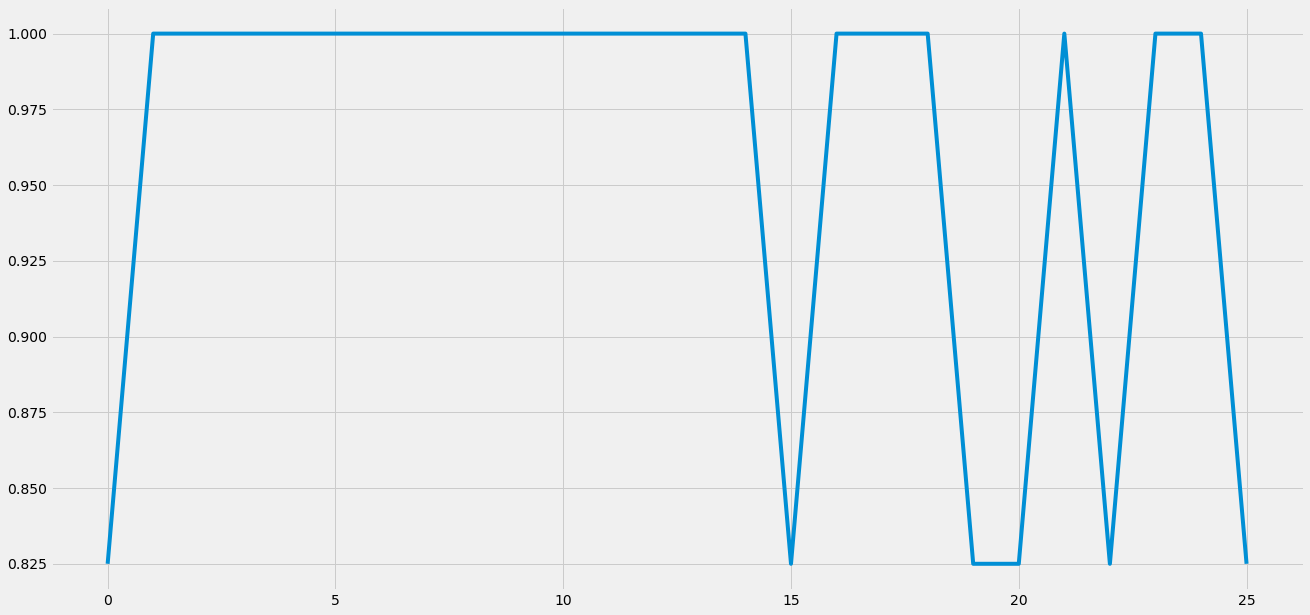

In [131]:
plt.plot(frac_list[::10])

In [132]:
actor_loss_list, critic_loss_list = [], []
for a_history, c_history in zip(history_actor_list, history_critic_list):
    actor_loss_list.append(a_history.history['loss'][-1])
    critic_loss_list.append(c_history.history['loss'][-1])

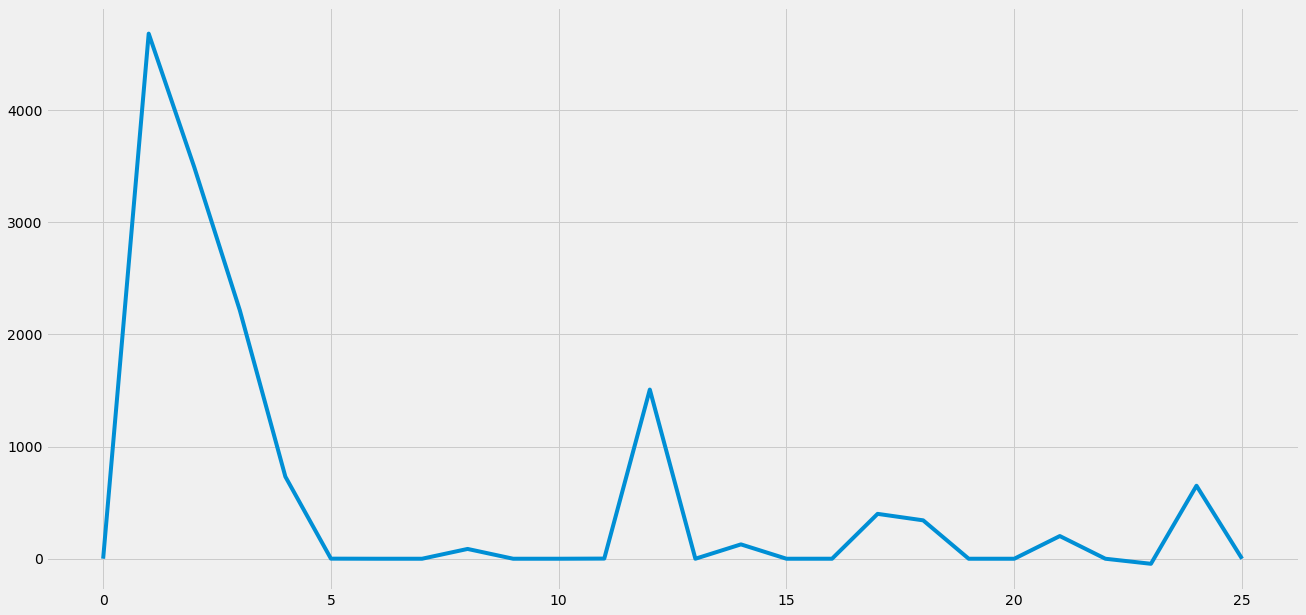

In [133]:
plt.plot(actor_loss_list[::10])

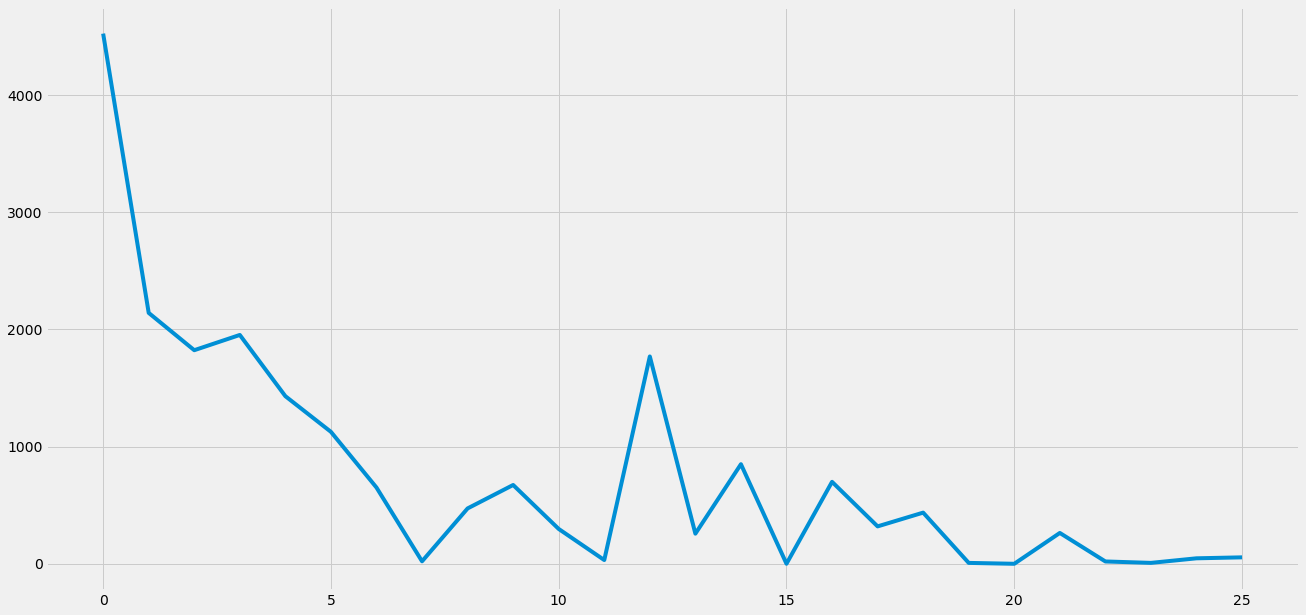

In [134]:
plt.plot(critic_loss_list[::10])

In [135]:
class A2CAgent2:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False

        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        self.actor = self.build_actor()
        self.critic = self.build_critic()
        
        self.target = np.zeros((1, self.value_size))
        self.advantages = np.zeros((1, self.action_size))

    def build_actor(self):
        actor = Sequential(name = 'actor')
        actor.add(Dense(24, input_dim=self.state_size, activation='relu'))
        if self.action_size == 1:
            actor.add(Dense(self.action_size, activation='linear'))
        else:
            actor.add(Dense(self.action_size, activation='softmax'))
        actor.summary()
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.actor_lr))
        return actor

    def build_critic(self):
        critic = Sequential(name = 'critic')
        critic.add(Dense(24, input_dim=self.state_size, activation='relu'))
        critic.add(Dense(self.value_size, activation='linear'))
        critic.summary()
        critic.compile(loss='mse', optimizer=Adam(lr=self.critic_lr))
        return critic

    def get_action(self, state, action_size):
        policy = self.actor.predict(state, batch_size=1).flatten()
        org_policy = policy
        #print('org:',  policy)
        
        if action_size > self.action_size:
            policy = policy[:action_size]
        elif action_size < self.action_size:
            policy = policy[:action_size]
            if sum(policy) == 0:
                if action_size == 1: policy = np.array([1.])
                elif action_size == 2: policy = np.array([0.5, 0.5])
                elif action_size == 3: policy = np.array([0.33, 0.33, 0.34])
            else:
                p_list = []
                #print('action:', action_size)
                for p in policy:
                    #print('p:', p, end=', ')
                    p_list.append(p)
                #print('')
                p_list = np.array(p_list)
                #print('p_list:',p_list,' sum:', sum(p_list))
                m = 1/sum(p_list)
                m = m
                for i in range(len(p_list)):
                    p_list[i] = p_list[i] * m
                policy = p_list
                #print('act:', action_size, 'org:', org_policy, 'p_list:', p_list, 'policy:', policy, 'sum:', sum(p_list), 'type:', type(policy[0]), 'isnan:', (np.nan==policy[0]))
        return np.random.choice(action_size, 1, p=policy)[0]

    def train_model(self, state, action, reward, next_state, done):
        value = self.critic.predict(state)[0]

        if done:
            self.advantages[0][action] = reward - value
            self.target[0][0] = reward
        else:
            next_value = self.critic.predict(next_state)[0]
            self.advantages[0][action] = reward + self.discount_factor * (next_value) - value
            self.target[0][0] = reward + self.discount_factor * next_value

        self.actor_history = self.actor.fit(state, self.advantages, epochs=1, verbose=0)
        self.critic_history = self.critic.fit(state, self.target, epochs=1, verbose=0)

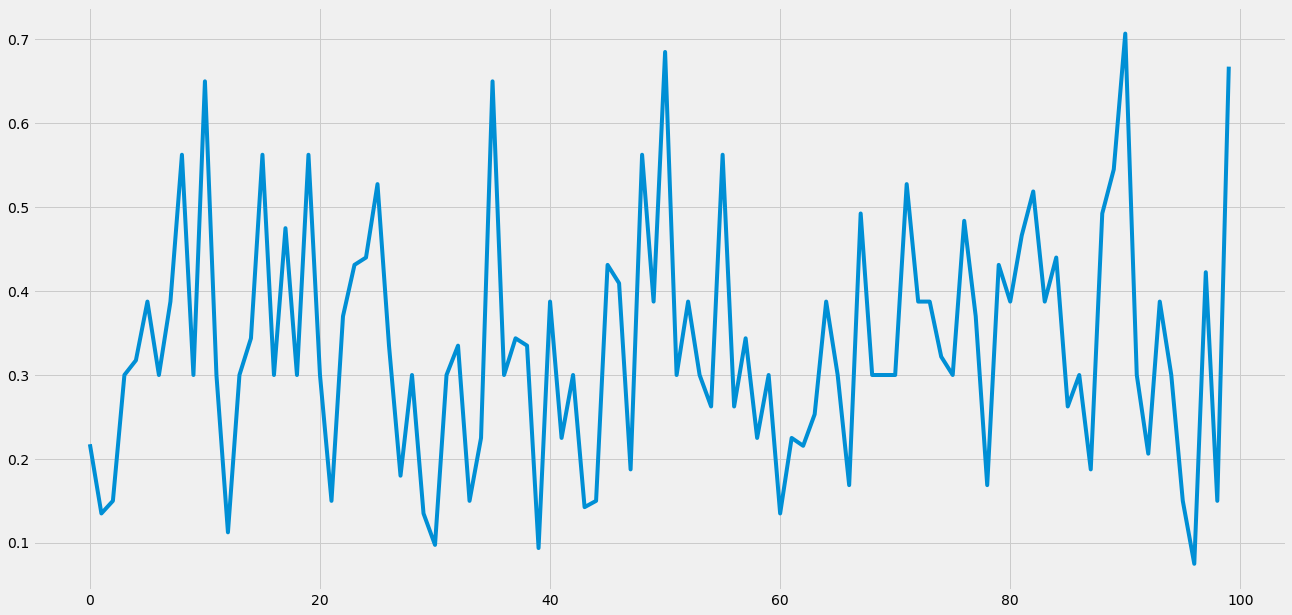

In [147]:
plt.plot(frac_list[::10])

In [148]:
actor_loss_list, critic_loss_list = [], []
for a_history, c_history in zip(history_actor_list, history_critic_list):
    actor_loss_list.append(a_history.history['loss'][-1])
    critic_loss_list.append(c_history.history['loss'][-1])

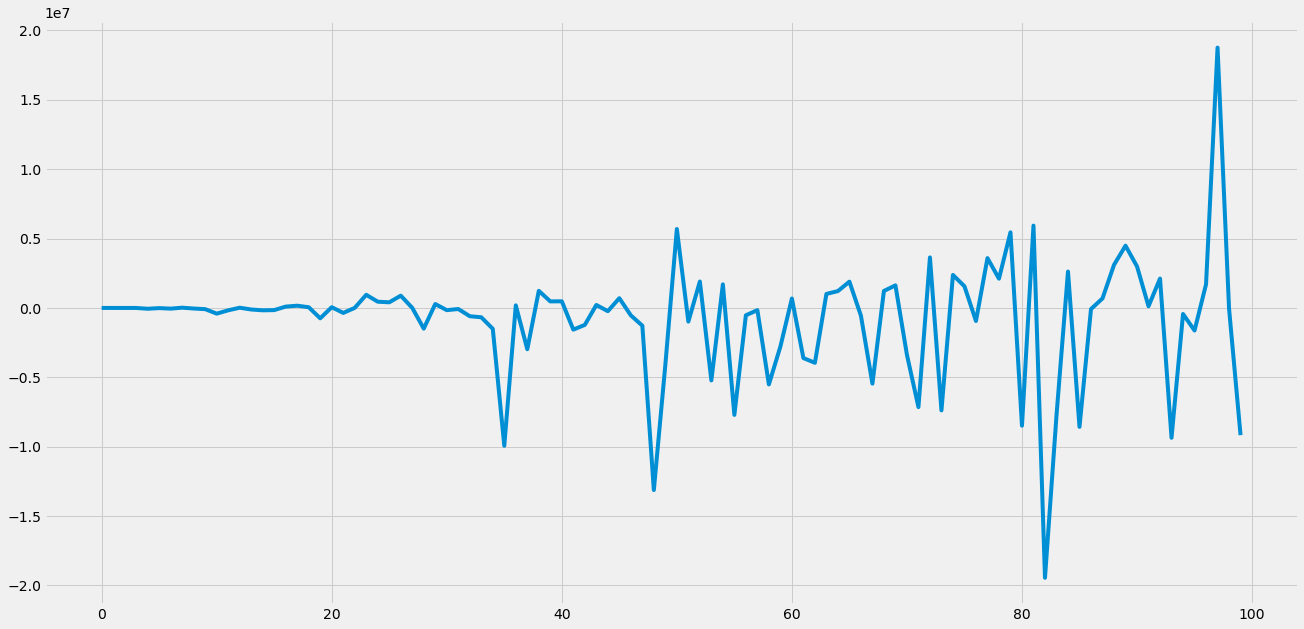

In [155]:
plt.plot(actor_loss_list[::10])

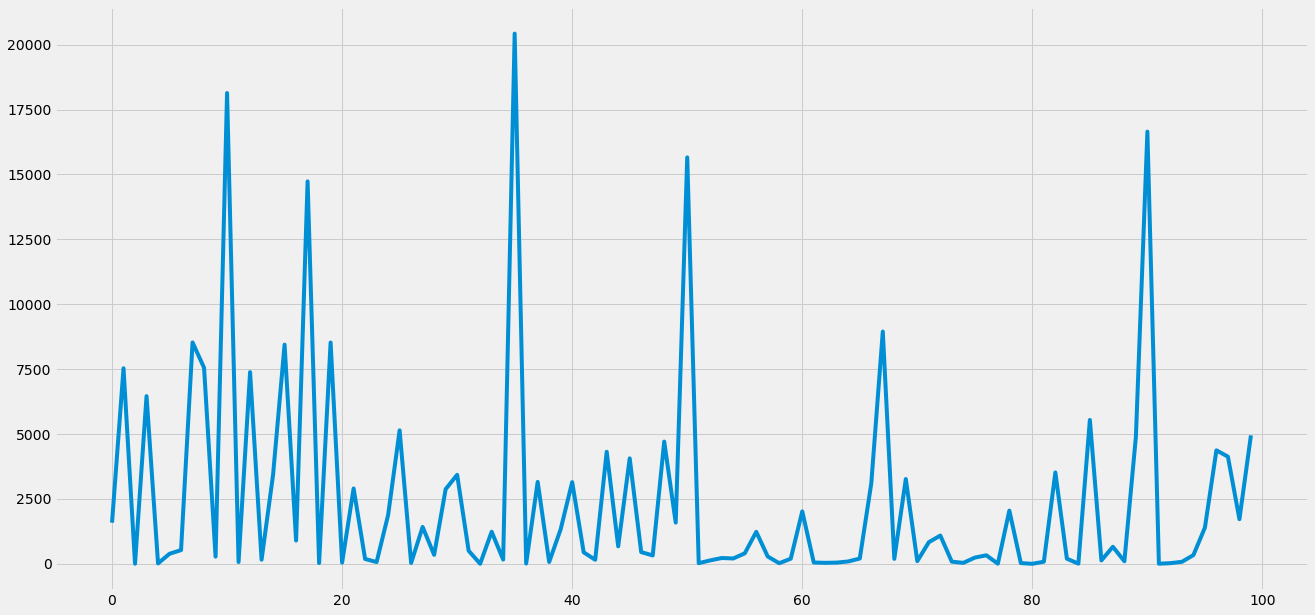

In [151]:
plt.plot(critic_loss_list[::10])

In [142]:
EPISODES = 1000

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent2(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 17

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
    boxes = boxes[0]

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        #print(len(f_upleft), action)
        #########
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_184 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_185 (Dense)            (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_187 (Dense)            (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________
Episode: 0, Reward: 21.75%, Actor Loss: [

Episode: 77, Reward: 43.12%, Actor Loss: [156478.9375], Critic Loss: [1654.3875732421875]
Episode: 78, Reward: 6.56%, Actor Loss: [546.125], Critic Loss: [4734.80322265625]
Episode: 79, Reward: 30.0%, Actor Loss: [-4597.357421875], Critic Loss: [56.00307846069336]
Episode: 80, Reward: 56.25%, Actor Loss: [-43308.33984375], Critic Loss: [7552.57958984375]
Episode: 81, Reward: 15.0%, Actor Loss: [-51170.21875], Critic Loss: [2333.259521484375]
Episode: 82, Reward: 15.0%, Actor Loss: [8838.2529296875], Critic Loss: [3512.68798828125]
Episode: 83, Reward: 65.0%, Actor Loss: [-14286.044921875], Critic Loss: [5.1615824699401855]
Episode: 84, Reward: 22.5%, Actor Loss: [70331.4921875], Critic Loss: [3546.29150390625]
Episode: 85, Reward: 30.0%, Actor Loss: [30157.05859375], Critic Loss: [279.8052062988281]
Episode: 86, Reward: 3.75%, Actor Loss: [4066.5810546875], Critic Loss: [6284.482421875]
Episode: 87, Reward: 58.44%, Actor Loss: [-12406.931640625], Critic Loss: [12398.7529296875]
Episode

Episode: 168, Reward: 43.12%, Actor Loss: [-418514.65625], Critic Loss: [8302.046875]
Episode: 169, Reward: 18.75%, Actor Loss: [-309707.1875], Critic Loss: [7.436639308929443]
Episode: 170, Reward: 47.5%, Actor Loss: [159904.171875], Critic Loss: [14731.001953125]
Episode: 171, Reward: 30.0%, Actor Loss: [-114784.0703125], Critic Loss: [124.3065414428711]
Episode: 172, Reward: 28.12%, Actor Loss: [96388.5078125], Critic Loss: [14.664589881896973]
Episode: 173, Reward: 30.0%, Actor Loss: [-360548.65625], Critic Loss: [78.18775939941406]
Episode: 174, Reward: 30.0%, Actor Loss: [-325559.625], Critic Loss: [204.17294311523438]
Episode: 175, Reward: 54.06%, Actor Loss: [-9937.75390625], Critic Loss: [4028.890380859375]
Episode: 176, Reward: 30.0%, Actor Loss: [23954.56640625], Critic Loss: [931.9662475585938]
Episode: 177, Reward: 47.5%, Actor Loss: [-799510.4375], Critic Loss: [6131.2060546875]
Episode: 178, Reward: 38.75%, Actor Loss: [-256652.25], Critic Loss: [1027.847412109375]
Episo

Episode: 260, Reward: 33.5%, Actor Loss: [884161.625], Critic Loss: [30.523534774780273]
Episode: 261, Reward: 47.5%, Actor Loss: [-1496812.875], Critic Loss: [2514.37451171875]
Episode: 262, Reward: 26.25%, Actor Loss: [-1679731.125], Critic Loss: [1495.087890625]
Episode: 263, Reward: 56.25%, Actor Loss: [-3166387.75], Critic Loss: [7796.99853515625]
Episode: 264, Reward: 30.0%, Actor Loss: [-850434.375], Critic Loss: [33.169715881347656]
Episode: 265, Reward: 5.62%, Actor Loss: [-181704.328125], Critic Loss: [5997.03662109375]
Episode: 266, Reward: 38.75%, Actor Loss: [-403372.90625], Critic Loss: [466.900146484375]
Episode: 267, Reward: 12.0%, Actor Loss: [447820.21875], Critic Loss: [0.903204619884491]
Episode: 268, Reward: 37.0%, Actor Loss: [984021.9375], Critic Loss: [1395.7574462890625]
Episode: 269, Reward: 30.0%, Actor Loss: [821648.375], Critic Loss: [1640.2314453125]
Episode: 270, Reward: 18.0%, Actor Loss: [4814.5625], Critic Loss: [1420.264892578125]
Episode: 271, Reward

Episode: 352, Reward: 18.75%, Actor Loss: [79759.171875], Critic Loss: [1294.28173828125]
Episode: 353, Reward: 42.25%, Actor Loss: [-3617.625], Critic Loss: [533.7481079101562]
Episode: 354, Reward: 30.0%, Actor Loss: [1830761.875], Critic Loss: [355.3736572265625]
Episode: 355, Reward: 22.5%, Actor Loss: [278851.5625], Critic Loss: [19.031898498535156]
Episode: 356, Reward: 13.5%, Actor Loss: [454268.0], Critic Loss: [1702.80712890625]
Episode: 357, Reward: 30.0%, Actor Loss: [-3385154.0], Critic Loss: [8623.490234375]
Episode: 358, Reward: 43.12%, Actor Loss: [-2945997.5], Critic Loss: [534.6473999023438]
Episode: 359, Reward: 35.25%, Actor Loss: [-910124.9375], Critic Loss: [277.5758056640625]
Episode: 360, Reward: 30.0%, Actor Loss: [184504.765625], Critic Loss: [11.160927772521973]
Episode: 361, Reward: 30.0%, Actor Loss: [-82070.9609375], Critic Loss: [3750.65234375]
Episode: 362, Reward: 22.5%, Actor Loss: [-1946293.25], Critic Loss: [1084.232666015625]
Episode: 363, Reward: 18

Episode: 444, Reward: 26.25%, Actor Loss: [-7361689.0], Critic Loss: [81.02897644042969]
Episode: 445, Reward: 30.0%, Actor Loss: [598120.4375], Critic Loss: [3001.796142578125]
Episode: 446, Reward: 62.81%, Actor Loss: [-1242134.5], Critic Loss: [10.553922653198242]
Episode: 447, Reward: 13.5%, Actor Loss: [-707965.0625], Critic Loss: [350.3319091796875]
Episode: 448, Reward: 37.0%, Actor Loss: [-2142878.0], Critic Loss: [2940.4208984375]
Episode: 449, Reward: 30.0%, Actor Loss: [-1132760.875], Critic Loss: [82.72265625]
Episode: 450, Reward: 43.12%, Actor Loss: [700739.8125], Critic Loss: [4061.387939453125]
Episode: 451, Reward: 65.0%, Actor Loss: [-12682340.0], Critic Loss: [10478.8408203125]
Episode: 452, Reward: 30.0%, Actor Loss: [201568.828125], Critic Loss: [1309.135986328125]
Episode: 453, Reward: 16.88%, Actor Loss: [-1235560.375], Critic Loss: [3353.58056640625]
Episode: 454, Reward: 38.75%, Actor Loss: [-2538034.25], Critic Loss: [1245.0692138671875]
Episode: 455, Reward: 

Episode: 537, Reward: 22.5%, Actor Loss: [1345012.125], Critic Loss: [183.59823608398438]
Episode: 538, Reward: 69.38%, Actor Loss: [-5667735.0], Critic Loss: [12082.369140625]
Episode: 539, Reward: 22.5%, Actor Loss: [-2703970.25], Critic Loss: [480.1599426269531]
Episode: 540, Reward: 26.25%, Actor Loss: [1697820.25], Critic Loss: [205.05474853515625]
Episode: 541, Reward: 26.25%, Actor Loss: [699263.75], Critic Loss: [851.4741821289062]
Episode: 542, Reward: 30.0%, Actor Loss: [774154.125], Critic Loss: [5.267401695251465]
Episode: 543, Reward: 43.12%, Actor Loss: [6137751.0], Critic Loss: [2187.45458984375]
Episode: 544, Reward: 9.75%, Actor Loss: [710106.8125], Critic Loss: [2649.262451171875]
Episode: 545, Reward: 20.62%, Actor Loss: [1755666.5], Critic Loss: [466.784423828125]
Episode: 546, Reward: 19.5%, Actor Loss: [245600.890625], Critic Loss: [3274.754638671875]
Episode: 547, Reward: 35.25%, Actor Loss: [1981640.0], Critic Loss: [51.945369720458984]
Episode: 548, Reward: 69.

Episode: 630, Reward: 25.31%, Actor Loss: [1009097.8125], Critic Loss: [46.01795196533203]
Episode: 631, Reward: 15.0%, Actor Loss: [-3677452.5], Critic Loss: [954.2128295898438]
Episode: 632, Reward: 38.75%, Actor Loss: [-10503107.0], Critic Loss: [4730.314453125]
Episode: 633, Reward: 42.25%, Actor Loss: [4001556.75], Critic Loss: [7546.77783203125]
Episode: 634, Reward: 43.12%, Actor Loss: [2327039.25], Critic Loss: [789.4182739257812]
Episode: 635, Reward: 30.0%, Actor Loss: [1230974.0], Critic Loss: [1477.1279296875]
Episode: 636, Reward: 18.75%, Actor Loss: [59643.015625], Critic Loss: [523.1305541992188]
Episode: 637, Reward: 30.0%, Actor Loss: [3355788.25], Critic Loss: [6.868133068084717]
Episode: 638, Reward: 34.38%, Actor Loss: [1778093.625], Critic Loss: [50.607669830322266]
Episode: 639, Reward: 47.5%, Actor Loss: [-1445680.875], Critic Loss: [711.9343872070312]
Episode: 640, Reward: 38.75%, Actor Loss: [1213344.75], Critic Loss: [89.9773941040039]
Episode: 641, Reward: 34

Episode: 723, Reward: 12.75%, Actor Loss: [-500148.53125], Critic Loss: [3781.5771484375]
Episode: 724, Reward: 47.5%, Actor Loss: [1603307.125], Critic Loss: [2354.373046875]
Episode: 725, Reward: 43.12%, Actor Loss: [-2369416.25], Critic Loss: [584.27587890625]
Episode: 726, Reward: 22.5%, Actor Loss: [1302066.25], Critic Loss: [139.4672088623047]
Episode: 727, Reward: 30.0%, Actor Loss: [2463945.25], Critic Loss: [518.8692626953125]
Episode: 728, Reward: 45.75%, Actor Loss: [-829239.625], Critic Loss: [5251.29736328125]
Episode: 729, Reward: 30.0%, Actor Loss: [-7073596.5], Critic Loss: [1747.8590087890625]
Episode: 730, Reward: 38.75%, Actor Loss: [-7385290.5], Critic Loss: [82.09903717041016]
Episode: 731, Reward: 22.5%, Actor Loss: [-1030711.875], Critic Loss: [614.1848754882812]
Episode: 732, Reward: 47.5%, Actor Loss: [-11810250.0], Critic Loss: [4196.7109375]
Episode: 733, Reward: 56.25%, Actor Loss: [-4746590.0], Critic Loss: [2052.05712890625]
Episode: 734, Reward: 30.0%, Ac

Episode: 816, Reward: 30.0%, Actor Loss: [1250817.125], Critic Loss: [2.2551987171173096]
Episode: 817, Reward: 12.0%, Actor Loss: [628337.25], Critic Loss: [540.0492553710938]
Episode: 818, Reward: 15.75%, Actor Loss: [-958940.5], Critic Loss: [347.52752685546875]
Episode: 819, Reward: 34.38%, Actor Loss: [-4411793.0], Critic Loss: [473.7972412109375]
Episode: 820, Reward: 51.88%, Actor Loss: [-19453382.0], Critic Loss: [3519.533203125]
Episode: 821, Reward: 38.75%, Actor Loss: [-1247992.25], Critic Loss: [1699.2030029296875]
Episode: 822, Reward: 38.75%, Actor Loss: [4138079.75], Critic Loss: [41.79213333129883]
Episode: 823, Reward: 22.5%, Actor Loss: [1715042.625], Critic Loss: [295.8028869628906]
Episode: 824, Reward: 30.0%, Actor Loss: [1847927.625], Critic Loss: [13.559309005737305]
Episode: 825, Reward: 30.0%, Actor Loss: [1686996.75], Critic Loss: [822.6356201171875]
Episode: 826, Reward: 30.0%, Actor Loss: [1785850.375], Critic Loss: [912.2831420898438]
Episode: 827, Reward: 

Episode: 909, Reward: 18.75%, Actor Loss: [1651193.25], Critic Loss: [436.9283752441406]
Episode: 910, Reward: 30.0%, Actor Loss: [118041.0625], Critic Loss: [3.03790283203125]
Episode: 911, Reward: 30.0%, Actor Loss: [-4810928.0], Critic Loss: [244.28369140625]
Episode: 912, Reward: 22.5%, Actor Loss: [-121249.7890625], Critic Loss: [1193.2767333984375]
Episode: 913, Reward: 22.5%, Actor Loss: [-191712.75], Critic Loss: [176.0023193359375]
Episode: 914, Reward: 22.5%, Actor Loss: [1810994.25], Critic Loss: [1902.9918212890625]
Episode: 915, Reward: 30.0%, Actor Loss: [-563111.4375], Critic Loss: [1927.4639892578125]
Episode: 916, Reward: 40.5%, Actor Loss: [-112799.171875], Critic Loss: [764.1783447265625]
Episode: 917, Reward: 22.5%, Actor Loss: [-1362686.75], Critic Loss: [18.287315368652344]
Episode: 918, Reward: 30.0%, Actor Loss: [-1947117.875], Critic Loss: [45.31595230102539]
Episode: 919, Reward: 32.19%, Actor Loss: [4722787.0], Critic Loss: [46.1948127746582]
Episode: 920, Re

In [141]:
EPISODES = 1000

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 1000

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
    boxes = boxes[0]

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        #print(len(f_upleft), action)
        #########
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_180 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_181 (Dense)            (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_182 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

In [ ]:
class A2CAgent_Option:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False

        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        self.actor = self.build_actor()
        self.critic = self.build_critic()

    def build_actor(self):
        actor = Sequential(name = 'actor')
        actor.add(Dense(24, input_dim=self.state_size, activation='relu'))
        if self.action_size == 1:
            actor.add(Dense(self.action_size, activation='linear'))
        else:
            actor.add(Dense(self.action_size, activation='softmax'))
        actor.summary()
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.actor_lr))
        return actor

    def build_critic(self):
        critic = Sequential(name = 'critic')
        critic.add(Dense(24, input_dim=self.state_size, activation='relu'))
        critic.add(Dense(self.value_size, activation='linear'))
        critic.summary()
        critic.compile(loss='mse', optimizer=Adam(lr=self.critic_lr))
        return critic

    def get_action(self, state, action_size):
        policy = self.actor.predict(state, batch_size=1).flatten()

        if action_size > self.action_size:
            policy = policy[:action_size]
        elif action_size < self.action_size:
            policy = policy[:action_size]
            if sum(policy) == 0:
                if action_size == 1: policy = np.array([1.])
                elif action_size == 2: policy = np.array([0.5, 0.5])
                elif action_size == 3: policy = np.array([0.33, 0.33, 0.34])
            else:
                p_list = []
                for p in policy:
                    p_list.append(p)
                p_list = np.array(p_list)
                m = 1/sum(p_list)
                m = m
                for i in range(len(p_list)):
                    p_list[i] = p_list[i] * m
                policy = p_list
        return np.random.choice(action_size, 1, p=policy)[0]

    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))
        value = self.critic.predict(state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            next_value = self.critic.predict(next_state)[0]
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor_history = self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic_history = self.critic.fit(state, target, epochs=1, verbose=0)

In [ ]:
EPISODES = 1000

env = Bpp3DEnv()
s_size = 20*20
a_size = 20*20
state_size = s_size+a_size
action_size = 4

agent = A2CAgent_Option(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 20

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
    boxes = boxes[0]

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        #action_option shape
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        #########
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)

In [156]:
EPISODES = 1000

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 7

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
    boxes = boxes[0]

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        #print(len(f_upleft), action)
        #########
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_188 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_189 (Dense)            (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_190 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________
Episode: 0, Reward: 65.0%, Actor Loss: [0

Episode: 87, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [10069.55078125]
Episode: 88, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [5987.30615234375]
Episode: 89, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [3751.297119140625]
Episode: 90, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [853.3270263671875]
Episode: 91, Reward: 100.0%, Actor Loss: [147702.90625], Critic Loss: [1146.252685546875]
Episode: 92, Reward: 100.0%, Actor Loss: [113930.3359375], Critic Loss: [557.4317626953125]
Episode: 93, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [1555.4873046875]
Episode: 94, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [3048.802001953125]
Episode: 95, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [1868.4697265625]
Episode: 96, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [2457.53955078125]
Episode: 97, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [1007.6720581054688]
Episode: 98, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [1043.583984375]
Episode: 99, Reward: 82.5%, 

Episode: 188, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [1647.7572021484375]
Episode: 189, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [10580.94921875]
Episode: 190, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [3061.59814453125]
Episode: 191, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [4766.20263671875]
Episode: 192, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [966.9944458007812]
Episode: 193, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [3151.752685546875]
Episode: 194, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [1130.2928466796875]
Episode: 195, Reward: 89.5%, Actor Loss: [0.0], Critic Loss: [4196.71337890625]
Episode: 196, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [1819.705322265625]
Episode: 197, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [603.7205200195312]
Episode: 198, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [1025.37548828125]
Episode: 199, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [7.9803924560546875]
Episode: 200, Reward: 100.0%, 

Episode: 289, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [28.585351943969727]
Episode: 290, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [292.0533752441406]
Episode: 291, Reward: 100.0%, Actor Loss: [3787543.0], Critic Loss: [3238.069580078125]
Episode: 292, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [561.9658203125]
Episode: 293, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [2923.565673828125]
Episode: 294, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [652.9044189453125]
Episode: 295, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [1888.2901611328125]
Episode: 296, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [1528.046875]
Episode: 297, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [58.474674224853516]
Episode: 298, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [796.1471557617188]
Episode: 299, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [5347.22998046875]
Episode: 300, Reward: 61.5%, Actor Loss: [0.0], Critic Loss: [7430.73681640625]
Episode: 301, Reward: 65.0%,

Episode: 390, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [1619.4779052734375]
Episode: 391, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [128.1477508544922]
Episode: 392, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [477.65118408203125]
Episode: 393, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [2127.21484375]
Episode: 394, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [510.29034423828125]
Episode: 395, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [730.9071044921875]
Episode: 396, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [1100.40673828125]
Episode: 397, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [4064.21826171875]
Episode: 398, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [6529.861328125]
Episode: 399, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [336.194580078125]
Episode: 400, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [1101.8887939453125]
Episode: 401, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [348.40960693359375]
Episode: 402, Reward: 82.5%, Act

Episode: 491, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [101.31886291503906]
Episode: 492, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [26.474994659423828]
Episode: 493, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [17.95830726623535]
Episode: 494, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [2477.633544921875]
Episode: 495, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [2240.391357421875]
Episode: 496, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [365.605712890625]
Episode: 497, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [536.8060302734375]
Episode: 498, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [278.0147705078125]
Episode: 499, Reward: 100.0%, Actor Loss: [10282929.0], Critic Loss: [2615.997314453125]
Episode: 500, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [386.778564453125]
Episode: 501, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [7105.669921875]
Episode: 502, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [14.803871154785156]
Episode: 503, Reward:

Episode: 592, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [3.0185720920562744]
Episode: 593, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [3428.343994140625]
Episode: 594, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [482.2194519042969]
Episode: 595, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [159.52377319335938]
Episode: 596, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [186.4739990234375]
Episode: 597, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [594.5211791992188]
Episode: 598, Reward: 100.0%, Actor Loss: [11399925.0], Critic Loss: [2283.410888671875]
Episode: 599, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [955.8320922851562]
Episode: 600, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [297.5814514160156]
Episode: 601, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [3796.309326171875]
Episode: 602, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [49.62974166870117]
Episode: 603, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [5.978359222412109]
Episode: 604, Rewa

Episode: 693, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [135.31202697753906]
Episode: 694, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [2427.837158203125]
Episode: 695, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [1068.3629150390625]
Episode: 696, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [350.3656005859375]
Episode: 697, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [864.6068115234375]
Episode: 698, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [466.6113586425781]
Episode: 699, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [587.4362182617188]
Episode: 700, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [10165.412109375]
Episode: 701, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [3852.2216796875]
Episode: 702, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [675.4950561523438]
Episode: 703, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [2178.775390625]
Episode: 704, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [1.2818125486373901]
Episode: 705, Reward: 65.0%, Act

Episode: 794, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [100.67633819580078]
Episode: 795, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [1125.052978515625]
Episode: 796, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [3506.320068359375]
Episode: 797, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [3102.732666015625]
Episode: 798, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [673.621337890625]
Episode: 799, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [771.6863403320312]
Episode: 800, Reward: 100.0%, Actor Loss: [6112046.0], Critic Loss: [158.97979736328125]
Episode: 801, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [0.17559190094470978]
Episode: 802, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [5.052788734436035]
Episode: 803, Reward: 100.0%, Actor Loss: [19160566.0], Critic Loss: [1566.7613525390625]
Episode: 804, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [769.71533203125]
Episode: 805, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [3816.2744140625]
Episode: 806,

Episode: 895, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [14.134288787841797]
Episode: 896, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [74.16666412353516]
Episode: 897, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [635.2859497070312]
Episode: 898, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [13.80057430267334]
Episode: 899, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [392.6222229003906]
Episode: 900, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [96.27467346191406]
Episode: 901, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [1484.843017578125]
Episode: 902, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [569.91943359375]
Episode: 903, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [326.8423156738281]
Episode: 904, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [1541.1854248046875]
Episode: 905, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [152.59201049804688]
Episode: 906, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [2381.408935546875]
Episode: 907, Reward: 65.0%

Episode: 996, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [357.49993896484375]
Episode: 997, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [40.80742645263672]
Episode: 998, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [1156.0592041015625]
Episode: 999, Reward: 30.0%, Actor Loss: [0.0], Critic Loss: [1796.271484375]


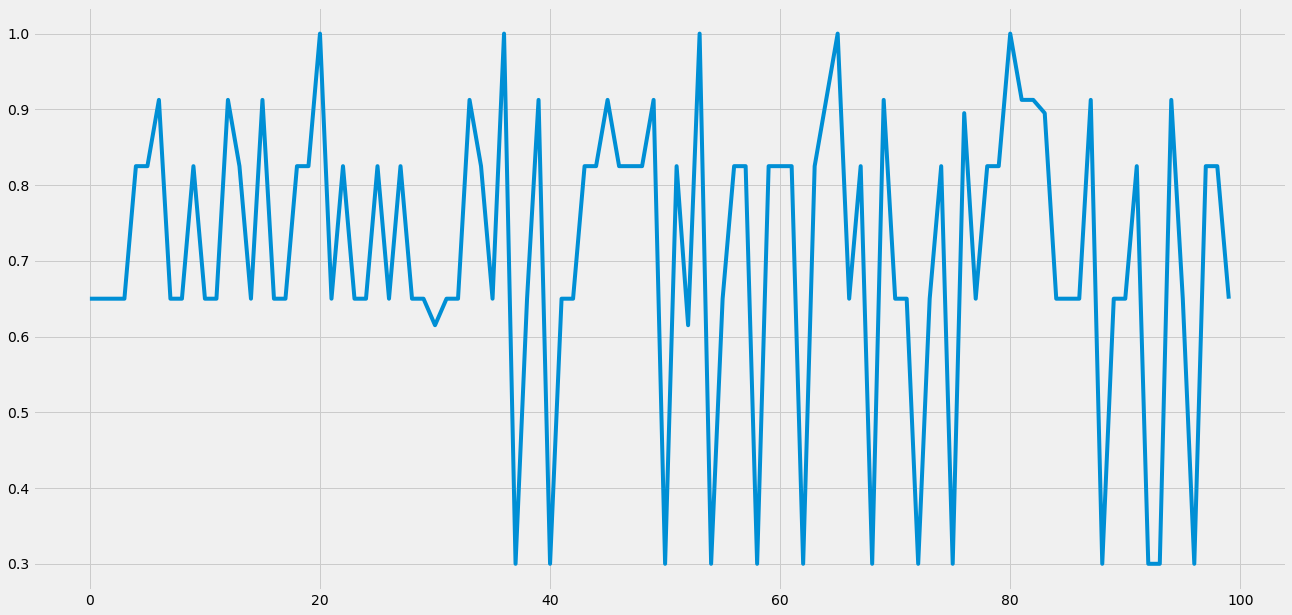

In [157]:
actor_loss_list, critic_loss_list = [], []
for a_history, c_history in zip(history_actor_list, history_critic_list):
    actor_loss_list.append(a_history.history['loss'][-1])
    critic_loss_list.append(c_history.history['loss'][-1])
plt.plot(frac_list[::10])

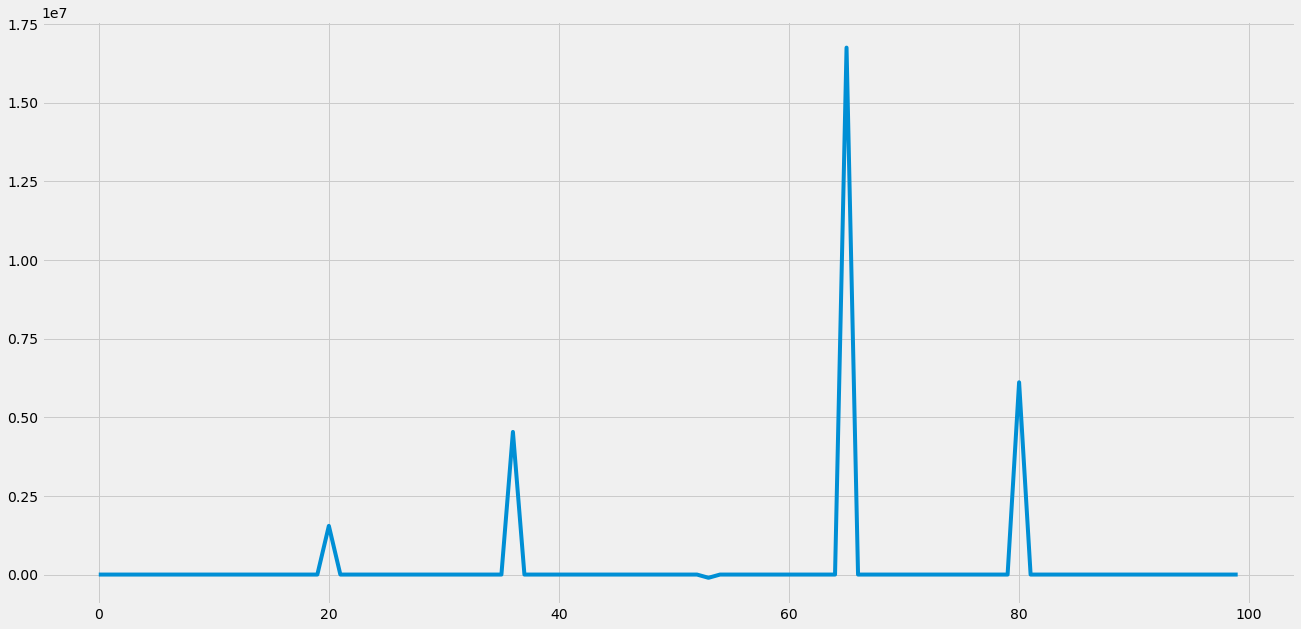

In [158]:
plt.plot(actor_loss_list[::10])

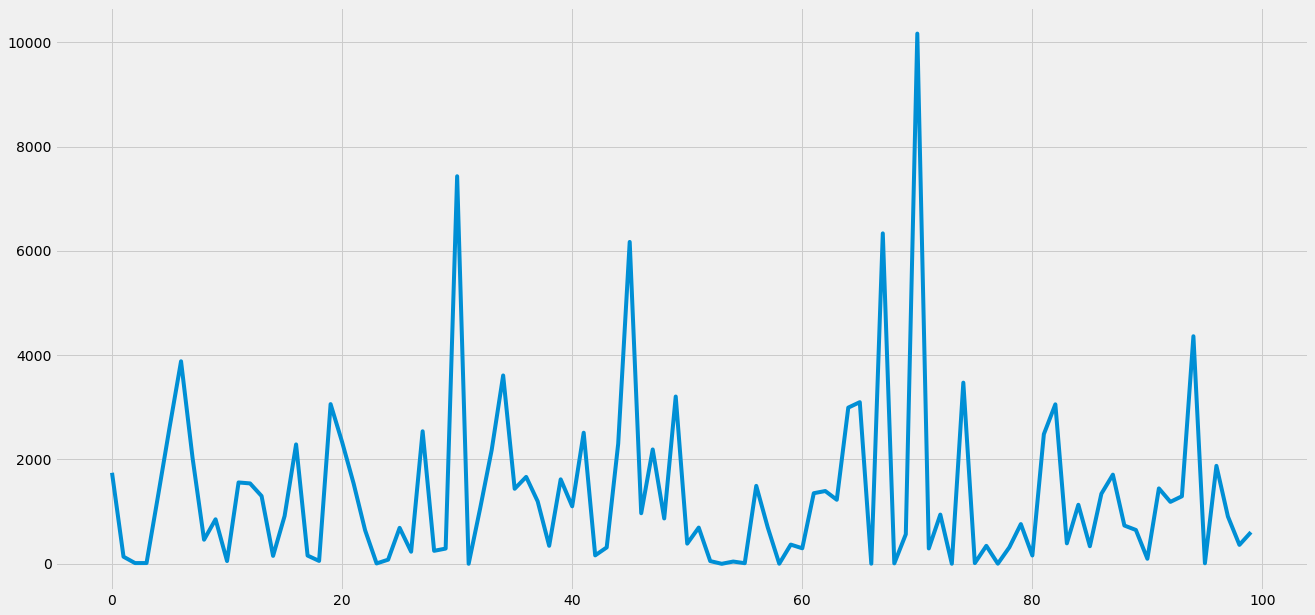

In [159]:
plt.plot(critic_loss_list[::10])

In [160]:
EPISODES = 1000

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 7
boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
boxes = boxes[0]

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        #print(len(f_upleft), action)
        #########
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_193 (Dense)            (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_194 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_195 (Dense)            (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________
Episode: 0, Reward: 82.5%, Actor Loss: [-

Episode: 78, Reward: 82.5%, Actor Loss: [-39278.4609375], Critic Loss: [9832.5732421875]
Episode: 79, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9830.14453125]
Episode: 80, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9827.7158203125]
Episode: 81, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9825.2841796875]
Episode: 82, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9822.8515625]
Episode: 83, Reward: 100.0%, Actor Loss: [-4.651309967041016], Critic Loss: [9820.41796875]
Episode: 84, Reward: 82.5%, Actor Loss: [-39879.640625], Critic Loss: [9817.9833984375]
Episode: 85, Reward: 82.5%, Actor Loss: [-41174.73046875], Critic Loss: [9815.5478515625]
Episode: 86, Reward: 82.5%, Actor Loss: [-44954.47265625], Critic Loss: [9813.111328125]
Episode: 87, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9810.6748046875]
Episode: 88, Reward: 82.5%, Actor Loss: [-48611.24609375], Critic Loss: [9808.2353515625]
Episode: 89, Reward: 82.5%, Actor Loss: [-51296.09375], Critic Loss: [98

Episode: 172, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9601.90234375]
Episode: 173, Reward: 82.5%, Actor Loss: [-234628.953125], Critic Loss: [9599.44140625]
Episode: 174, Reward: 82.5%, Actor Loss: [-238835.8125], Critic Loss: [9596.98046875]
Episode: 175, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9594.5205078125]
Episode: 176, Reward: 82.5%, Actor Loss: [-244934.703125], Critic Loss: [9592.060546875]
Episode: 177, Reward: 100.0%, Actor Loss: [-0.0001984535192605108], Critic Loss: [9589.5986328125]
Episode: 178, Reward: 82.5%, Actor Loss: [-248276.578125], Critic Loss: [9587.1396484375]
Episode: 179, Reward: 82.5%, Actor Loss: [-251899.375], Critic Loss: [9584.6787109375]
Episode: 180, Reward: 82.5%, Actor Loss: [-255063.625], Critic Loss: [9582.21875]
Episode: 181, Reward: 82.5%, Actor Loss: [-264200.71875], Critic Loss: [9579.7587890625]
Episode: 182, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9577.2998046875]
Episode: 183, Reward: 82.5%, Actor Loss: [-271951.03

Episode: 269, Reward: 82.5%, Actor Loss: [-471407.03125], Critic Loss: [9364.083984375]
Episode: 270, Reward: 82.5%, Actor Loss: [-476051.96875], Critic Loss: [9361.64453125]
Episode: 271, Reward: 82.5%, Actor Loss: [-483570.6875], Critic Loss: [9359.2060546875]
Episode: 272, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9356.767578125]
Episode: 273, Reward: 82.5%, Actor Loss: [-488619.8125], Critic Loss: [9354.328125]
Episode: 274, Reward: 82.5%, Actor Loss: [-498179.8125], Critic Loss: [9351.8896484375]
Episode: 275, Reward: 82.5%, Actor Loss: [-506120.90625], Critic Loss: [9349.4521484375]
Episode: 276, Reward: 82.5%, Actor Loss: [-515266.625], Critic Loss: [9347.0146484375]
Episode: 277, Reward: 82.5%, Actor Loss: [-524996.5], Critic Loss: [9344.5771484375]
Episode: 278, Reward: 82.5%, Actor Loss: [-535014.3125], Critic Loss: [9342.1396484375]
Episode: 279, Reward: 82.5%, Actor Loss: [-545179.6875], Critic Loss: [9339.7041015625]
Episode: 280, Reward: 82.5%, Actor Loss: [-555425

Episode: 366, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9128.9296875]
Episode: 367, Reward: 100.0%, Actor Loss: [-50.433048248291016], Critic Loss: [9126.521484375]
Episode: 368, Reward: 82.5%, Actor Loss: [-1071606.75], Critic Loss: [9124.11328125]
Episode: 369, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9121.70703125]
Episode: 370, Reward: 82.5%, Actor Loss: [-1073699.125], Critic Loss: [9119.2998046875]
Episode: 371, Reward: 82.5%, Actor Loss: [-1077905.0], Critic Loss: [9116.892578125]
Episode: 372, Reward: 82.5%, Actor Loss: [-1086440.0], Critic Loss: [9114.486328125]
Episode: 373, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9112.0810546875]
Episode: 374, Reward: 82.5%, Actor Loss: [-1095589.25], Critic Loss: [9109.6748046875]
Episode: 375, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [9107.26953125]
Episode: 376, Reward: 82.5%, Actor Loss: [-1098594.375], Critic Loss: [9104.865234375]
Episode: 377, Reward: 82.5%, Actor Loss: [-1102749.25], Critic Loss: [9102.

Episode: 463, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [8896.974609375]
Episode: 464, Reward: 82.5%, Actor Loss: [-1609859.875], Critic Loss: [8894.6005859375]
Episode: 465, Reward: 82.5%, Actor Loss: [-1614970.875], Critic Loss: [8892.2275390625]
Episode: 466, Reward: 82.5%, Actor Loss: [-1625064.5], Critic Loss: [8889.853515625]
Episode: 467, Reward: 82.5%, Actor Loss: [-1637487.625], Critic Loss: [8887.4814453125]
Episode: 468, Reward: 82.5%, Actor Loss: [-1651031.0], Critic Loss: [8885.107421875]
Episode: 469, Reward: 82.5%, Actor Loss: [-1665115.875], Critic Loss: [8882.736328125]
Episode: 470, Reward: 82.5%, Actor Loss: [-1679467.125], Critic Loss: [8880.36328125]
Episode: 471, Reward: 82.5%, Actor Loss: [-1693953.5], Critic Loss: [8877.9921875]
Episode: 472, Reward: 82.5%, Actor Loss: [-1708510.625], Critic Loss: [8875.6220703125]
Episode: 473, Reward: 82.5%, Actor Loss: [-1723109.375], Critic Loss: [8873.25]
Episode: 474, Reward: 82.5%, Actor Loss: [-1737737.0], Critic L

Episode: 560, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [8668.341796875]
Episode: 561, Reward: 82.5%, Actor Loss: [-2649620.25], Critic Loss: [8666.001953125]
Episode: 562, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [8663.662109375]
Episode: 563, Reward: 82.5%, Actor Loss: [-2655065.75], Critic Loss: [8661.3232421875]
Episode: 564, Reward: 82.5%, Actor Loss: [-2652861.0], Critic Loss: [8658.984375]
Episode: 565, Reward: 82.5%, Actor Loss: [-2663702.0], Critic Loss: [8656.646484375]
Episode: 566, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [8654.30859375]
Episode: 567, Reward: 82.5%, Actor Loss: [-2672700.0], Critic Loss: [8651.970703125]
Episode: 568, Reward: 82.5%, Actor Loss: [-2679024.0], Critic Loss: [8649.6328125]
Episode: 569, Reward: 82.5%, Actor Loss: [-2690607.75], Critic Loss: [8647.2958984375]
Episode: 570, Reward: 82.5%, Actor Loss: [-2704719.0], Critic Loss: [8644.958984375]
Episode: 571, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [8642.6240234375]
Epis

Episode: 657, Reward: 82.5%, Actor Loss: [-3805660.5], Critic Loss: [8443.033203125]
Episode: 658, Reward: 82.5%, Actor Loss: [-3817970.75], Critic Loss: [8440.7265625]
Episode: 659, Reward: 82.5%, Actor Loss: [-3833212.25], Critic Loss: [8438.421875]
Episode: 660, Reward: 82.5%, Actor Loss: [-3849863.5], Critic Loss: [8436.1162109375]
Episode: 661, Reward: 82.5%, Actor Loss: [-3867199.5], Critic Loss: [8433.8115234375]
Episode: 662, Reward: 82.5%, Actor Loss: [-3884872.5], Critic Loss: [8431.5078125]
Episode: 663, Reward: 82.5%, Actor Loss: [-3902712.5], Critic Loss: [8429.2041015625]
Episode: 664, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [8426.900390625]
Episode: 665, Reward: 82.5%, Actor Loss: [-3913583.0], Critic Loss: [8424.59765625]
Episode: 666, Reward: 82.5%, Actor Loss: [-3919681.25], Critic Loss: [8422.2939453125]
Episode: 667, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [8419.9921875]
Episode: 668, Reward: 100.0%, Actor Loss: [-6217.0], Critic Loss: [8417.69042968

Episode: 755, Reward: 82.5%, Actor Loss: [-5077815.5], Critic Loss: [8218.7490234375]
Episode: 756, Reward: 82.5%, Actor Loss: [-5122991.5], Critic Loss: [8216.4765625]
Episode: 757, Reward: 82.5%, Actor Loss: [-5141855.5], Critic Loss: [8214.2060546875]
Episode: 758, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [8211.935546875]
Episode: 759, Reward: 82.5%, Actor Loss: [-5151781.0], Critic Loss: [8209.6650390625]
Episode: 760, Reward: 82.5%, Actor Loss: [-5157705.0], Critic Loss: [8207.39453125]
Episode: 761, Reward: 82.5%, Actor Loss: [-5171014.0], Critic Loss: [8205.125]
Episode: 762, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [8202.85546875]
Episode: 763, Reward: 82.5%, Actor Loss: [-5177354.0], Critic Loss: [8200.5869140625]
Episode: 764, Reward: 82.5%, Actor Loss: [-5182707.0], Critic Loss: [8198.318359375]
Episode: 765, Reward: 82.5%, Actor Loss: [-5195563.5], Critic Loss: [8196.0498046875]
Episode: 766, Reward: 82.5%, Actor Loss: [-5212022.0], Critic Loss: [8193.78125]
E

Episode: 852, Reward: 82.5%, Actor Loss: [-6377237.5], Critic Loss: [8000.02978515625]
Episode: 853, Reward: 100.0%, Actor Loss: [0.0], Critic Loss: [7997.7919921875]
Episode: 854, Reward: 82.5%, Actor Loss: [-6389817.0], Critic Loss: [7995.55419921875]
Episode: 855, Reward: 82.5%, Actor Loss: [-6395723.5], Critic Loss: [7993.31640625]
Episode: 856, Reward: 82.5%, Actor Loss: [-6410147.5], Critic Loss: [7991.07958984375]
Episode: 857, Reward: 82.5%, Actor Loss: [-6428144.5], Critic Loss: [7988.8427734375]
Episode: 858, Reward: 82.5%, Actor Loss: [-6447860.0], Critic Loss: [7986.60595703125]
Episode: 859, Reward: 82.5%, Actor Loss: [-6468400.0], Critic Loss: [7984.36962890625]
Episode: 860, Reward: 82.5%, Actor Loss: [-6489347.0], Critic Loss: [7982.1337890625]
Episode: 861, Reward: 82.5%, Actor Loss: [-6510487.5], Critic Loss: [7979.8984375]
Episode: 862, Reward: 82.5%, Actor Loss: [-6531728.5], Critic Loss: [7977.6630859375]
Episode: 863, Reward: 82.5%, Actor Loss: [-6553023.5], Criti

Episode: 948, Reward: 82.5%, Actor Loss: [-8137281.0], Critic Loss: [7786.73876953125]
Episode: 949, Reward: 82.5%, Actor Loss: [-8173751.0], Critic Loss: [7784.53369140625]
Episode: 950, Reward: 82.5%, Actor Loss: [-8192043.0], Critic Loss: [7782.32861328125]
Episode: 951, Reward: 82.5%, Actor Loss: [-8212500.5], Critic Loss: [7780.12353515625]
Episode: 952, Reward: 82.5%, Actor Loss: [-8234004.5], Critic Loss: [7777.91943359375]
Episode: 953, Reward: 82.5%, Actor Loss: [-8256014.0], Critic Loss: [7775.71533203125]
Episode: 954, Reward: 82.5%, Actor Loss: [-8278268.5], Critic Loss: [7773.51123046875]
Episode: 955, Reward: 82.5%, Actor Loss: [-8300649.5], Critic Loss: [7771.30908203125]
Episode: 956, Reward: 82.5%, Actor Loss: [-8323091.5], Critic Loss: [7769.10595703125]
Episode: 957, Reward: 82.5%, Actor Loss: [-8345571.0], Critic Loss: [7766.9033203125]
Episode: 958, Reward: 82.5%, Actor Loss: [-8368069.5], Critic Loss: [7764.7021484375]
Episode: 959, Reward: 82.5%, Actor Loss: [-83

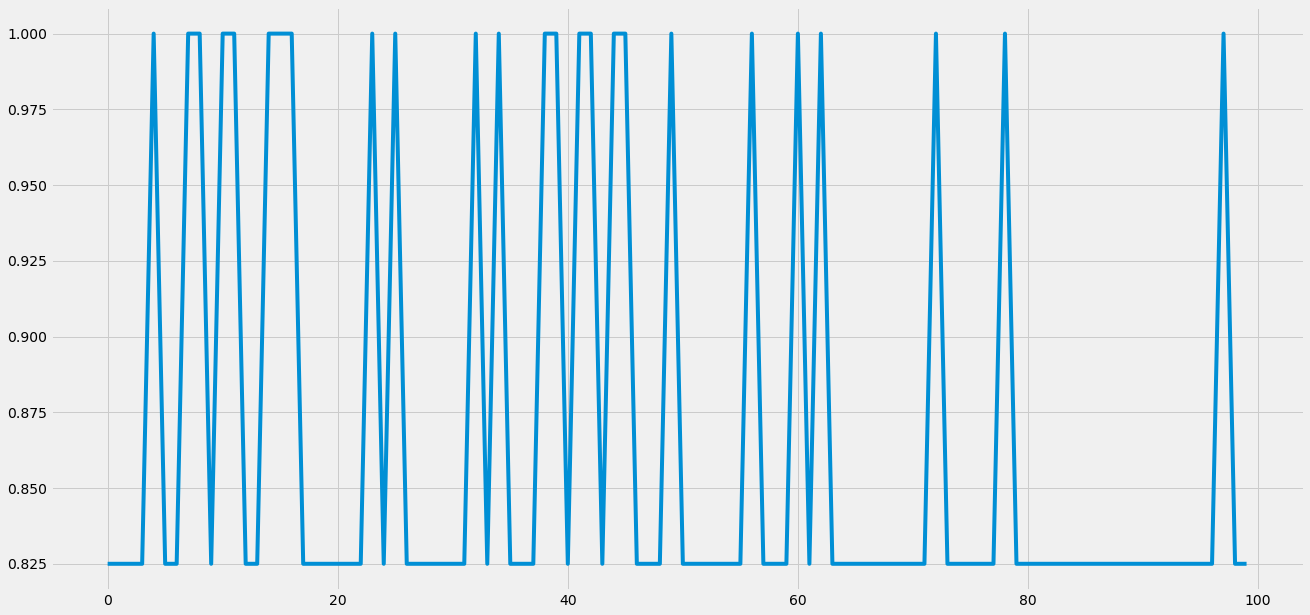

In [161]:
actor_loss_list, critic_loss_list = [], []
for a_history, c_history in zip(history_actor_list, history_critic_list):
    actor_loss_list.append(a_history.history['loss'][-1])
    critic_loss_list.append(c_history.history['loss'][-1])
plt.plot(frac_list[::10])

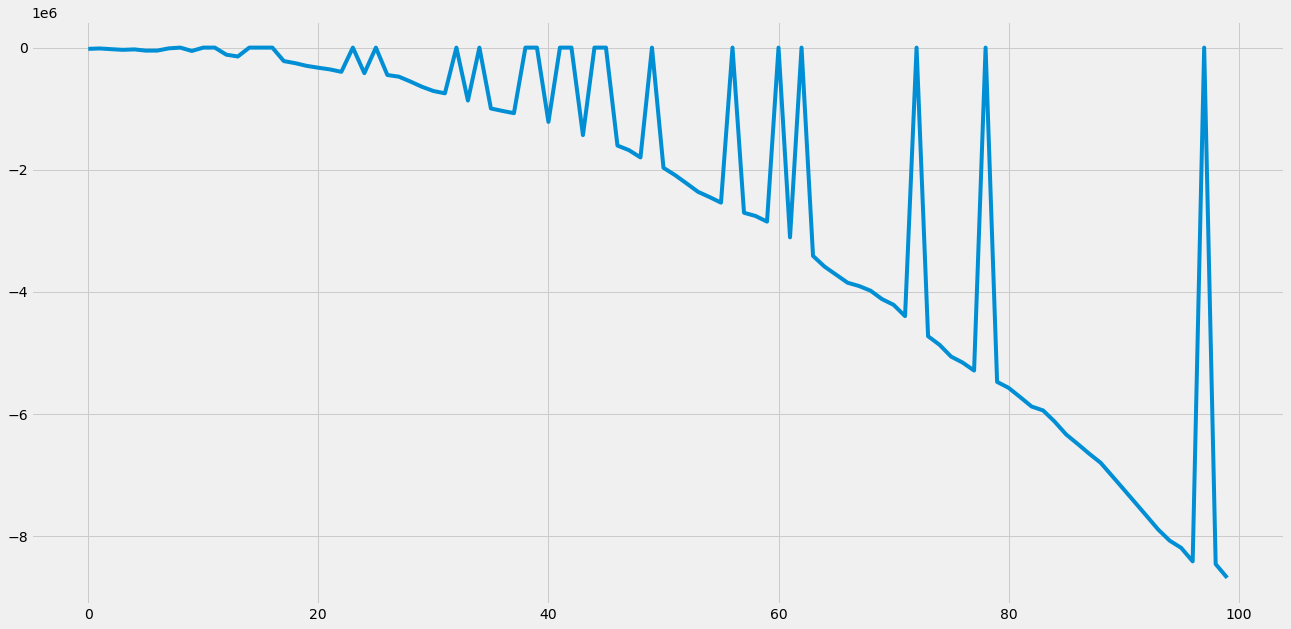

In [162]:
plt.plot(actor_loss_list[::10])

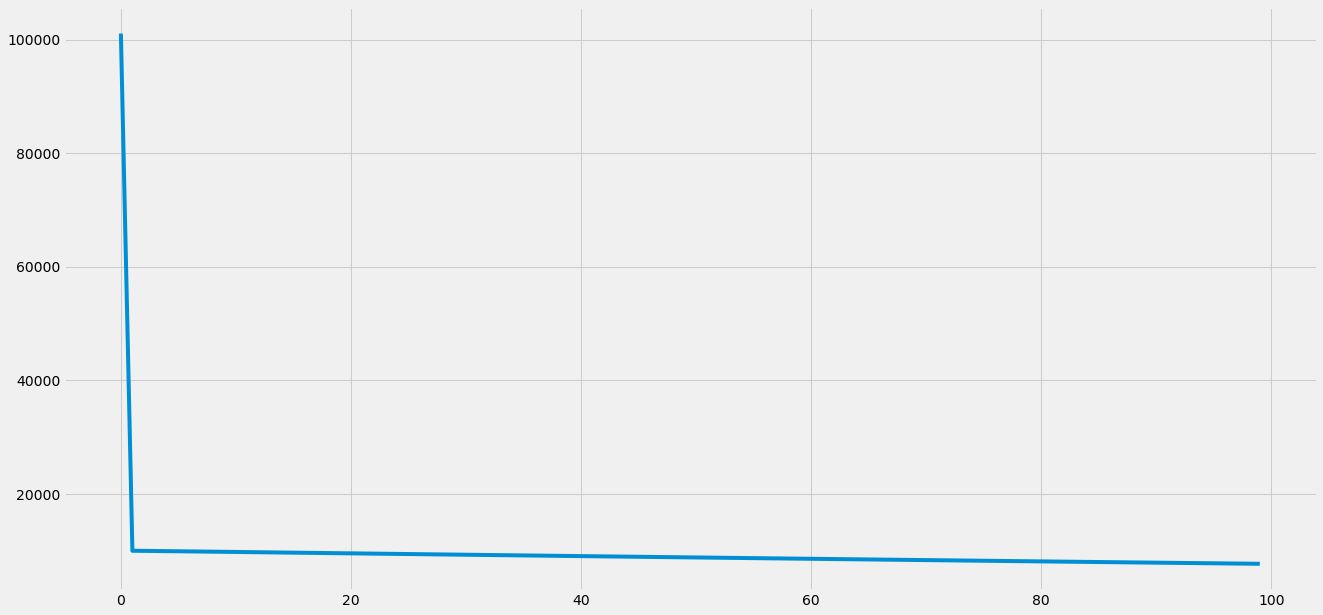

In [163]:
plt.plot(critic_loss_list[::10])

In [164]:
EPISODES = 1000

env = Bpp3DEnv()
state_size = 20 * 20
action_size = 4

agent = A2CAgent(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 7
boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
boxes = boxes[0]

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    np.random.shuffle(boxes)

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        #print(len(f_upleft), action)
        #########
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_197 (Dense)            (None, 4)                 100       
Total params: 9,724
Trainable params: 9,724
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_198 (Dense)            (None, 24)                9624      
_________________________________________________________________
dense_199 (Dense)            (None, 1)                 25        
Total params: 9,649
Trainable params: 9,649
Non-trainable params: 0
_________________________________________________________________
Episode: 0, Reward: 58.75%, Actor Loss: [

Episode: 86, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [7638.572265625]
Episode: 87, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [1012.155517578125]
Episode: 88, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [1416.7982177734375]
Episode: 89, Reward: 73.75%, Actor Loss: [0.0], Critic Loss: [1003.0380859375]
Episode: 90, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [2220.775634765625]
Episode: 91, Reward: 76.25%, Actor Loss: [0.0], Critic Loss: [2422.16845703125]
Episode: 92, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [2193.024658203125]
Episode: 93, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [2259.9638671875]
Episode: 94, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [9.416420936584473]
Episode: 95, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [174.0256805419922]
Episode: 96, Reward: 52.5%, Actor Loss: [0.0], Critic Loss: [5.310986518859863]
Episode: 97, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [3914.91796875]
Episode: 98, Reward: 82.5%, Actor Loss: [0.0]

Episode: 188, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [30.000926971435547]
Episode: 189, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [3520.299072265625]
Episode: 190, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [688.6035766601562]
Episode: 191, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [1447.298828125]
Episode: 192, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [1824.7325439453125]
Episode: 193, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [1746.5157470703125]
Episode: 194, Reward: 56.25%, Actor Loss: [0.0], Critic Loss: [1126.573486328125]
Episode: 195, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [3460.87744140625]
Episode: 196, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [3389.783447265625]
Episode: 197, Reward: 56.25%, Actor Loss: [0.0], Critic Loss: [239.0158233642578]
Episode: 198, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [666.9005126953125]
Episode: 199, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [603.5851440429688]
Episode: 200, Reward: 

Episode: 290, Reward: 76.25%, Actor Loss: [0.0], Critic Loss: [372.1114807128906]
Episode: 291, Reward: 73.75%, Actor Loss: [0.0], Critic Loss: [625.6856689453125]
Episode: 292, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [3565.822509765625]
Episode: 293, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [242.79612731933594]
Episode: 294, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [959.6948852539062]
Episode: 295, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [1962.5186767578125]
Episode: 296, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [1365.9461669921875]
Episode: 297, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [955.4717407226562]
Episode: 298, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [93.9629898071289]
Episode: 299, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [280.2645568847656]
Episode: 300, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [765.1192626953125]
Episode: 301, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [1995.1824951171875]
Episode: 302, Rew

Episode: 391, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [2183.867919921875]
Episode: 392, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [4268.49365234375]
Episode: 393, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [4908.6513671875]
Episode: 394, Reward: 50.0%, Actor Loss: [0.0], Critic Loss: [103.85993957519531]
Episode: 395, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [166.72572326660156]
Episode: 396, Reward: 73.75%, Actor Loss: [0.0], Critic Loss: [236.64195251464844]
Episode: 397, Reward: 50.0%, Actor Loss: [0.0], Critic Loss: [49.47249221801758]
Episode: 398, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [8534.07421875]
Episode: 399, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [35.79083251953125]
Episode: 400, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [415.55889892578125]
Episode: 401, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [726.2410888671875]
Episode: 402, Reward: 56.25%, Actor Loss: [0.0], Critic Loss: [0.11874174326658249]
Episode: 403, Reward: 8

Episode: 492, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [269.26568603515625]
Episode: 493, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [38.29903793334961]
Episode: 494, Reward: 56.25%, Actor Loss: [0.0], Critic Loss: [322.1604919433594]
Episode: 495, Reward: 50.0%, Actor Loss: [0.0], Critic Loss: [366.69451904296875]
Episode: 496, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [3992.260986328125]
Episode: 497, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [5102.283203125]
Episode: 498, Reward: 50.0%, Actor Loss: [0.0], Critic Loss: [6396.130859375]
Episode: 499, Reward: 76.25%, Actor Loss: [0.0], Critic Loss: [0.4600480794906616]
Episode: 500, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [1455.56640625]
Episode: 501, Reward: 73.75%, Actor Loss: [0.0], Critic Loss: [59.304168701171875]
Episode: 502, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [925.533203125]
Episode: 503, Reward: 76.25%, Actor Loss: [0.0], Critic Loss: [483.1222229003906]
Episode: 504, Reward: 67.5%, Acto

Episode: 594, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [1.3040729761123657]
Episode: 595, Reward: 76.25%, Actor Loss: [0.0], Critic Loss: [57.23503494262695]
Episode: 596, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [180.2440185546875]
Episode: 597, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [279.5648193359375]
Episode: 598, Reward: 43.75%, Actor Loss: [0.0], Critic Loss: [17.609098434448242]
Episode: 599, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [328.0995178222656]
Episode: 600, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [9140.005859375]
Episode: 601, Reward: 50.0%, Actor Loss: [0.0], Critic Loss: [69.93707275390625]
Episode: 602, Reward: 50.0%, Actor Loss: [0.0], Critic Loss: [4.728680610656738]
Episode: 603, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [1746.455810546875]
Episode: 604, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [279.5076599121094]
Episode: 605, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [5373.9150390625]
Episode: 606, Reward: 73.

Episode: 696, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [78.62674713134766]
Episode: 697, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [95.25897979736328]
Episode: 698, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [952.4884643554688]
Episode: 699, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [1330.8291015625]
Episode: 700, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [2987.760986328125]
Episode: 701, Reward: 76.25%, Actor Loss: [0.0], Critic Loss: [1065.8736572265625]
Episode: 702, Reward: 76.25%, Actor Loss: [0.0], Critic Loss: [2189.987548828125]
Episode: 703, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [1462.0191650390625]
Episode: 704, Reward: 17.5%, Actor Loss: [0.0], Critic Loss: [3074.817626953125]
Episode: 705, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [604.5917358398438]
Episode: 706, Reward: 82.5%, Actor Loss: [0.0], Critic Loss: [0.010704430751502514]
Episode: 707, Reward: 73.75%, Actor Loss: [0.0], Critic Loss: [792.3843383789062]
Episode: 708, Rewar

Episode: 797, Reward: 91.25%, Actor Loss: [0.0], Critic Loss: [4248.875]
Episode: 798, Reward: 52.5%, Actor Loss: [0.0], Critic Loss: [623.5470581054688]
Episode: 799, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [448.7989501953125]
Episode: 800, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [30.618362426757812]
Episode: 801, Reward: 50.0%, Actor Loss: [0.0], Critic Loss: [371.4536437988281]
Episode: 802, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [677.33447265625]
Episode: 803, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [2194.083984375]
Episode: 804, Reward: 73.75%, Actor Loss: [0.0], Critic Loss: [1337.0640869140625]
Episode: 805, Reward: 73.75%, Actor Loss: [0.0], Critic Loss: [806.7667846679688]
Episode: 806, Reward: 47.5%, Actor Loss: [0.0], Critic Loss: [319.7041320800781]
Episode: 807, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [1758.5875244140625]
Episode: 808, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [1539.95166015625]
Episode: 809, Reward: 73.75%, Actor

Episode: 898, Reward: 35.0%, Actor Loss: [0.0], Critic Loss: [1.7357789278030396]
Episode: 899, Reward: 17.5%, Actor Loss: [0.0], Critic Loss: [1150.677001953125]
Episode: 900, Reward: 58.75%, Actor Loss: [0.0], Critic Loss: [1408.102294921875]
Episode: 901, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [19690.71875]
Episode: 902, Reward: 56.25%, Actor Loss: [0.0], Critic Loss: [490.79766845703125]
Episode: 903, Reward: 32.5%, Actor Loss: [0.0], Critic Loss: [1126.2437744140625]
Episode: 904, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [180.986572265625]
Episode: 905, Reward: 65.0%, Actor Loss: [0.0], Critic Loss: [194.20095825195312]
Episode: 906, Reward: 17.5%, Actor Loss: [0.0], Critic Loss: [1472.24951171875]
Episode: 907, Reward: 43.75%, Actor Loss: [0.0], Critic Loss: [39.281578063964844]
Episode: 908, Reward: 52.5%, Actor Loss: [0.0], Critic Loss: [67.68901062011719]
Episode: 909, Reward: 67.5%, Actor Loss: [0.0], Critic Loss: [1810.610595703125]
Episode: 910, Reward: 58.75%

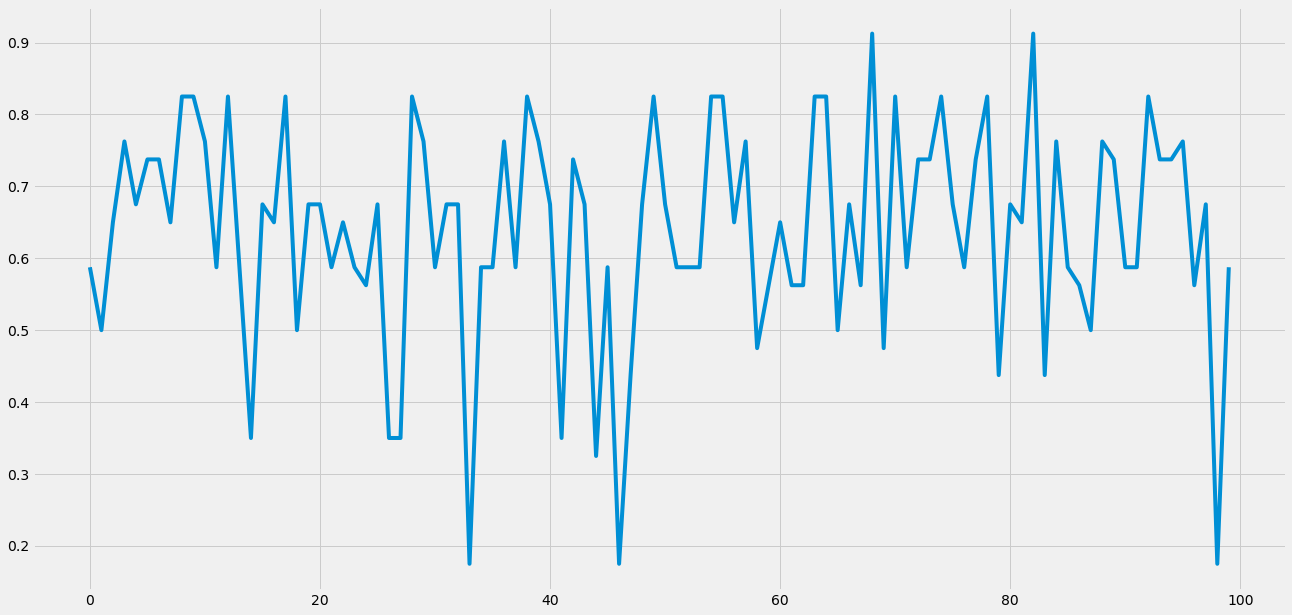

In [165]:
actor_loss_list, critic_loss_list = [], []
for a_history, c_history in zip(history_actor_list, history_critic_list):
    actor_loss_list.append(a_history.history['loss'][-1])
    critic_loss_list.append(c_history.history['loss'][-1])
plt.plot(frac_list[::10])

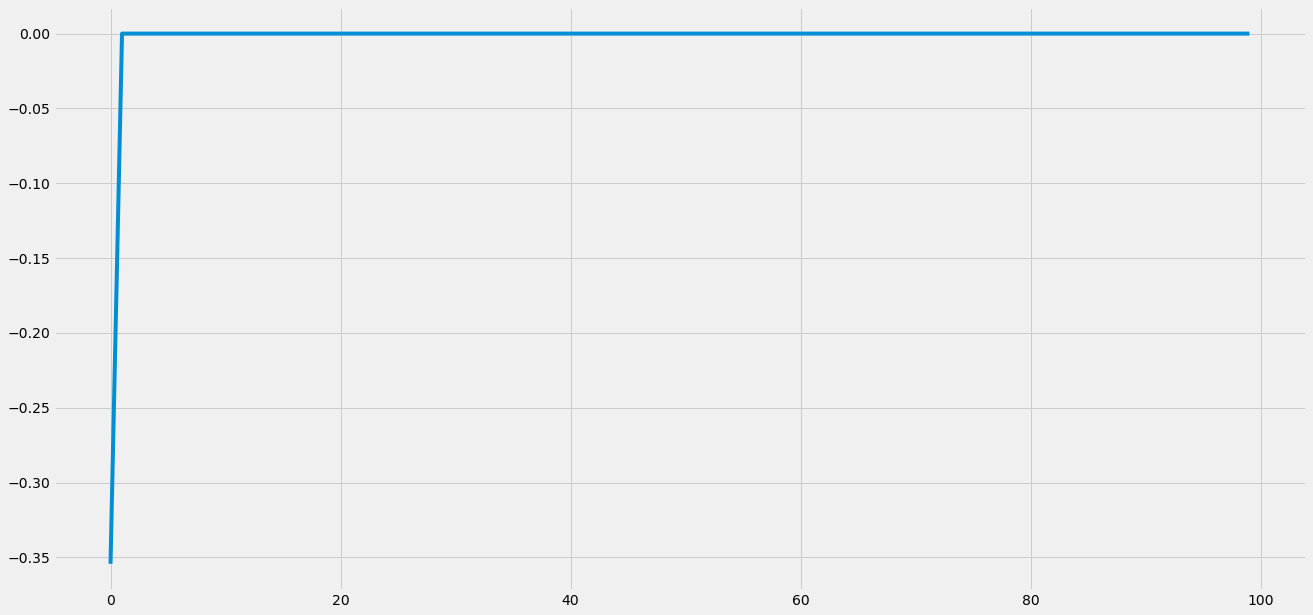

In [166]:
plt.plot(actor_loss_list[::10])

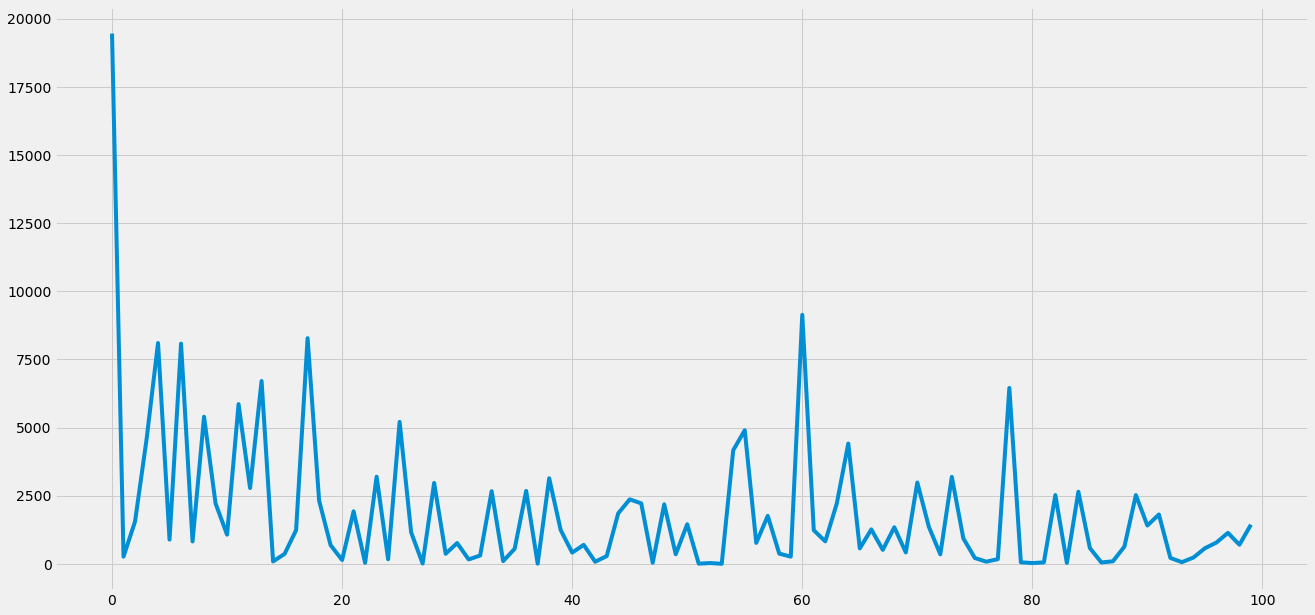

In [167]:
plt.plot(critic_loss_list[::10])

In [ ]:
a = [1.6971365e-01, 3.9797279e-01, 4.3231067e-01, 2.8737229e-06]
a = np.array(a)
a

In [44]:
p_list = []
for p in a:
    p_list.append(p)
p_list = np.array(p_list)
sum(a)

0.9999999837229

In [ ]:
policy = policy[:action_size]
p_list = []
for p in policy:
    p_list.append(p)
p_list = np.array(p_list)
m = 1/sum(p_list)
m = m
for i in range(len(p_list)):
    p_list[i] = p_list[i] * m
policy = p_list

In [79]:
a = np.array([0,1,2])
if np.nan in a:
    print('True')
print(True in np.isnan(a))

False


In [ ]:
class A2CAgent_Option:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False

        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        self.actor = self.build_actor()
        self.critic = self.build_critic()

    def build_actor(self):
        actor = Sequential(name = 'actor')
        actor.add(Dense(24, input_dim=self.state_size, activation='relu'))
        if self.action_size == 1:
            actor.add(Dense(self.action_size, activation='linear'))
        else:
            actor.add(Dense(self.action_size, activation='softmax'))
        actor.summary()
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.actor_lr))
        return actor

    def build_critic(self):
        critic = Sequential(name = 'critic')
        critic.add(Dense(24, input_dim=self.state_size, activation='relu'))
        critic.add(Dense(self.value_size, activation='linear'))
        critic.summary()
        critic.compile(loss='mse', optimizer=Adam(lr=self.critic_lr))
        return critic

    def get_action(self, state, action_size):
        policy = self.actor.predict(state, batch_size=1).flatten()

        if action_size > self.action_size:
            policy = policy[:action_size]
        elif action_size < self.action_size:
            policy = policy[:action_size]
            if sum(policy) == 0:
                if action_size == 1: policy = np.array([1.])
                elif action_size == 2: policy = np.array([0.5, 0.5])
                elif action_size == 3: policy = np.array([0.33, 0.33, 0.34])
            else:
                p_list = []
                for p in policy:
                    p_list.append(p)
                p_list = np.array(p_list)
                m = 1/sum(p_list)
                m = m
                for i in range(len(p_list)):
                    p_list[i] = p_list[i] * m
                policy = p_list
        return np.random.choice(action_size, 1, p=policy)[0]

    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))
        value = self.critic.predict(state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            next_value = self.critic.predict(next_state)[0]
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor_history = self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic_history = self.critic.fit(state, target, epochs=1, verbose=0)

In [ ]:
EPISODES = 1000

env = Bpp3DEnv()
s_size = 20*20
a_size = 20*20
state_size = s_size+a_size
action_size = 4

agent = A2CAgent_Option(state_size, action_size)
scores, episodes = [], []
frac_list, history_actor_list, history_critic_list = [], [], []

N_MDD = 20

for episode in range(EPISODES):
    st = time.time()
    done = False
    score = 0
    env.reset()
    
    boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1, 
                                     N_mdd=N_MDD, is_prediv='2h')
    boxes = boxes[0]

    step = 0
    while not done:
        history = env.container.copy()
        box = boxes[step]
        w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
        step += 1

        f_upleft = feasible_location(history, w_upleft, box[0], box[1], box[2], 
                                     state_H = env.height, is2d=False)
        state = history.flatten()
        state = np.reshape(state, [1, state_size])
        #action_option shape
        
        if len(f_upleft) == 0:
            done = True
            action = -1
        else:
            action = agent.get_action(state, len(f_upleft))
        #########
        
        if not done:
            next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
            next_state = np.reshape(next_state, [1, state_size])

            if step == len(boxes):
                done = True

        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        #state = next_state

        if done:
            frac_list.append(env.terminal_reward())
            history_actor_list.append(agent.actor_history)
            history_critic_list.append(agent.critic_history)

            score = score if score == 500.0 else score + 100
            
            log = 'Episode: ' + str(episode)
            log += ', Reward: ' + str(round(env.terminal_reward() * 100,2)) + '%'
            log += ', Actor Loss: ' + str(agent.actor_history.history['loss'])
            log += ', Critic Loss: ' + str(agent.critic_history.history['loss'])
            
            print(log)